# Buy/Sell signals for the Mexican Equity Index
## Alfonso Camacho Bustillo - 28 Jul 2024

### The goal of this project is to test different ML models to generate Buy/Sell signals for an Equity Index, in this the case of the Mexican Bolsa index. The models are built based on daily public data from the exchange, a set of technical indicators on that same index and some basic data of the Mexican currency, Interest Rates and VIX (US Volatility index) as an additional market sentiment reference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pathlib as pl
import os
import itertools
from IPython.display import clear_output

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.base import clone
import seaborn as sns
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import clone

from time import time

# LOAD DATA

In [3]:
def validate_file(file_path):
    """
    Validate if the file exists.
    """
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
        
# Function to load the saved data from a CSV file
def load_data(file_path):
    """
    Load the DataFrame from the specified CSV file.
    """
    validate_file(file_path)
    df = pd.read_csv(file_path, parse_dates=['Date'])
    print(f"Data loaded from {file_path}")
    return df

In [4]:
# UPLOAD Data

# Load the data from the latest file (replace the timestamp with the actual one you want to load)
load_directory = "/Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/Output_files/"
base_name = "V2_processed_data_reduced_inputs"

#time_stamp_d="20240724_1654" #1 day forecast + vs -
#time_stamp_d="20240725_0731" #5 day forecast - threshold 0.5%
#time_stamp_d='20240725_1236'  #5 day forecast + vs -
#time_stamp_d='20240725_1743'  #5 day and NEW data
time_stamp_d='20240725_1833'   #1 day and NEW data

full_file_name = f"{load_directory}{base_name}_{time_stamp_d}.csv"
file_path = full_file_name
df_reduced = load_data(file_path)

#print(df_reduced.head())

Data loaded from /Users/macponcho/a_IMPERIAL_COLLEGE/0_ProyectoNN/Output_files/V2_processed_data_reduced_inputs_20240725_1833.csv


### Plot function

In [6]:
def plot_time_series(df, column, plot_yearly=False):
    """
    Plot time series for the specified column. Optionally plot yearly blocks as matrix plots.
    """
    # Ensure the data is sorted by Date
    df = df.sort_values(by='Date')
    
    if plot_yearly:
        df['Year'] = df['Date'].dt.year
        years = df['Year'].unique()
        num_years = len(years)
        num_cols = 3
        num_rows = (num_years + num_cols - 1) // num_cols  # Ensure enough rows to fit all years
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), sharex=False, sharey=False)
        axes = axes.flatten()

        for i, year in enumerate(years):
            yearly_data = df[df['Year'] == year]
            sns.lineplot(data=yearly_data, x='Date', y=column, ax=axes[i])
            axes[i].set_title(f'{column} in {year}')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel(column)

        for j in range(i + 1, num_rows * num_cols):
            fig.delaxes(axes[j])  # Remove unused subplots

        plt.tight_layout()
    else:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df, x='Date', y=column)
        plt.title(f'{column} Over Time')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.show()


# Take cleaned data and split in train, val and test


#### Functions to Split, standardize and stratify data

In [9]:
# Function to split data
def split_data(df, train_size=0.79, val_size=0.005):  #Test = 1 - train - val    
    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    
    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]
    
    return train_df, val_df, test_df

# Check and Handle NaN/Infinite Values
def check_and_handle_invalid_values(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

# Function to standardize data and return DataFrames identical to the original ones with labeled features
def standardize_data(train_df, val_df, test_df=None):
    scaler = StandardScaler()
    features = train_df.drop(columns=['return_category', 'Date', 'forward_return']).columns

    # Fit the scaler on the training data and transform
    train_scaled = scaler.fit_transform(train_df[features])
    val_scaled = scaler.transform(val_df[features])

    # Convert the scaled arrays back to DataFrames with the same column names and indices
    train_scaled_df = pd.DataFrame(train_scaled, columns=features, index=train_df.index)
    val_scaled_df = pd.DataFrame(val_scaled, columns=features, index=val_df.index)
    
    # Reintroduce the dropped features
    train_scaled_df = pd.concat([train_scaled_df, train_df[['return_category', 'Date', 'forward_return']]], axis=1)
    val_scaled_df = pd.concat([val_scaled_df, val_df[['return_category', 'Date', 'forward_return']]], axis=1)
    
    if test_df is not None:
        test_scaled = scaler.transform(test_df[features])
        test_scaled_df = pd.DataFrame(test_scaled, columns=features, index=test_df.index)
        test_scaled_df = pd.concat([test_scaled_df, test_df[['return_category', 'Date', 'forward_return']]], axis=1)
        return train_scaled_df, val_scaled_df, test_scaled_df, scaler

    return train_scaled_df, val_scaled_df, scaler

def generate_descriptive_info(df):
    desc_stats = df.describe()
    category_counts = df['return_category'].value_counts()
    return desc_stats, category_counts



In [10]:
# Function to ensure stratification (NOT USED FOR NOW)
'''def stratify_data(df, stratify_column='return_category'):
    stratifier = StratifiedKFold(n_splits=5)
    for train_index, val_index in stratifier.split(df, df[stratify_column]):
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]
    return train_df, val_df'''


"def stratify_data(df, stratify_column='return_category'):\n    stratifier = StratifiedKFold(n_splits=5)\n    for train_index, val_index in stratifier.split(df, df[stratify_column]):\n        train_df = df.iloc[train_index]\n        val_df = df.iloc[val_index]\n    return train_df, val_df"

# Main: Split data

In [12]:
# Main Process
dfm = df_reduced

# Split Data
train_df, val_df, test_df = split_data(dfm)

# Split features and target variable
X_train = train_df.drop(columns=['return_category', 'Date', 'forward_return'])
y_train = train_df['return_category']
X_val = val_df.drop(columns=['return_category', 'Date', 'forward_return'])
y_val = val_df['return_category']
X_test = test_df.drop(columns=['return_category', 'Date', 'forward_return'])
y_test = test_df['return_category']



In [13]:
# Assuming train_df, val_df, and test_df are already defined
train_scaled_df, val_scaled_df, test_scaled_df, scaler = standardize_data(train_df, val_df, test_df)

# Split features and target variable
X_train_scaled_df = train_scaled_df.drop(columns=['return_category', 'Date', 'forward_return'])
y_train_scaled_df = train_scaled_df['return_category']
X_val_scaled_df = val_scaled_df.drop(columns=['return_category', 'Date', 'forward_return'])
y_val_scaled_df = val_scaled_df['return_category']
X_test_scaled_df = test_scaled_df.drop(columns=['return_category', 'Date', 'forward_return'])
y_test_scaled_df = test_scaled_df['return_category']

In [14]:
# Generate Descriptive Information
train_desc, train_counts = generate_descriptive_info(train_df)
val_desc, val_counts = generate_descriptive_info(val_df)
test_desc, test_counts = generate_descriptive_info(test_df)

print("Training Data Category Counts:\n", train_counts)
print("Validation Data Category Counts:\n", val_counts)
print("Test Data Category Counts:\n", test_counts)

Training Data Category Counts:
 return_category
1    2233
0    1955
Name: count, dtype: int64
Validation Data Category Counts:
 return_category
1    15
0    12
Name: count, dtype: int64
Test Data Category Counts:
 return_category
1    548
0    539
Name: count, dtype: int64


In [15]:
#print("Training Data Description:\n", train_desc)
#print("Validation Data Description:\n", val_desc)
#print("Test Data Description:\n", test_desc)

# Plot splitted series if needed

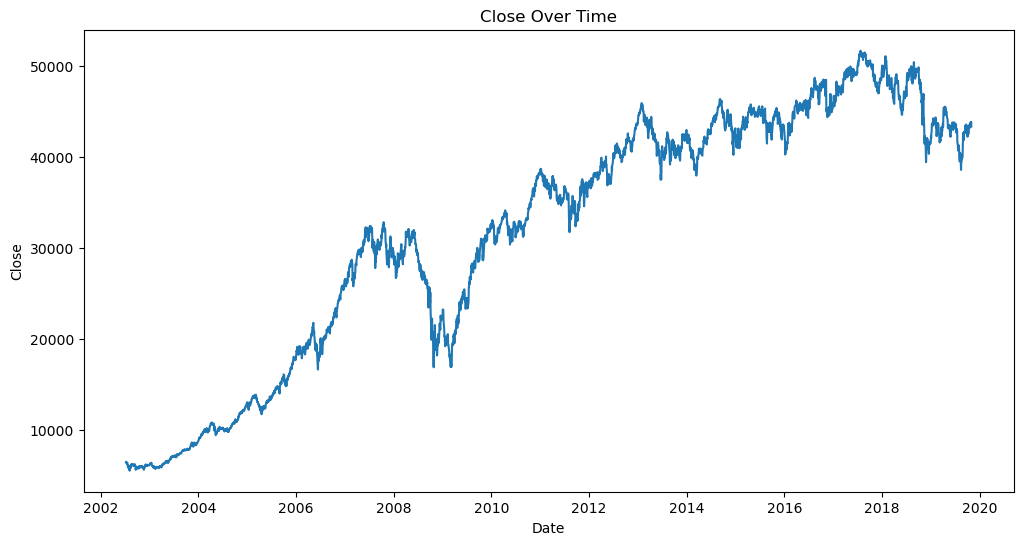

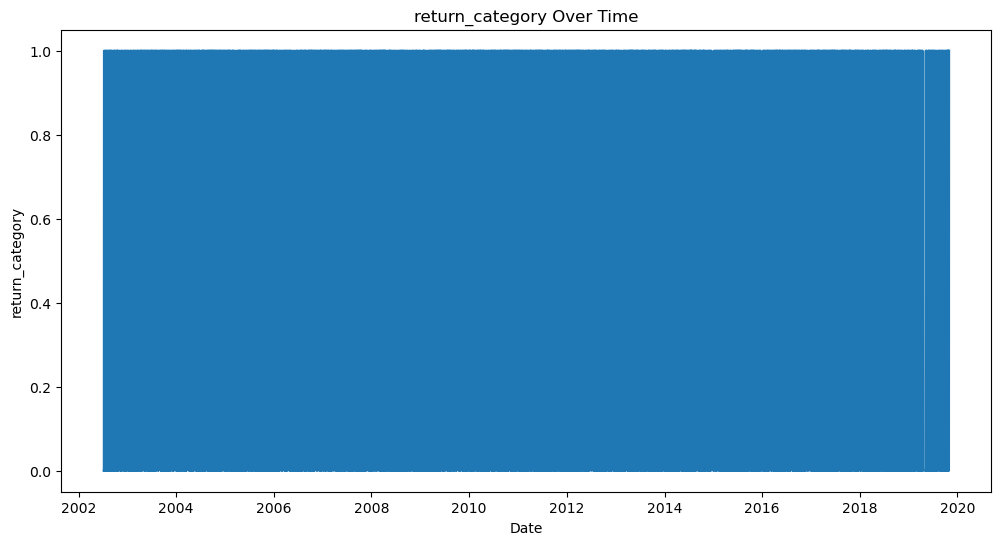

In [17]:
# Plot Train data

train_df.loc[:, 'Date'] = pd.to_datetime(train_df['Date'], format='%d/%m/%Y')
plot_time_series(train_df, column='Close', plot_yearly=False)
plot_time_series(train_df, column='return_category', plot_yearly=False)

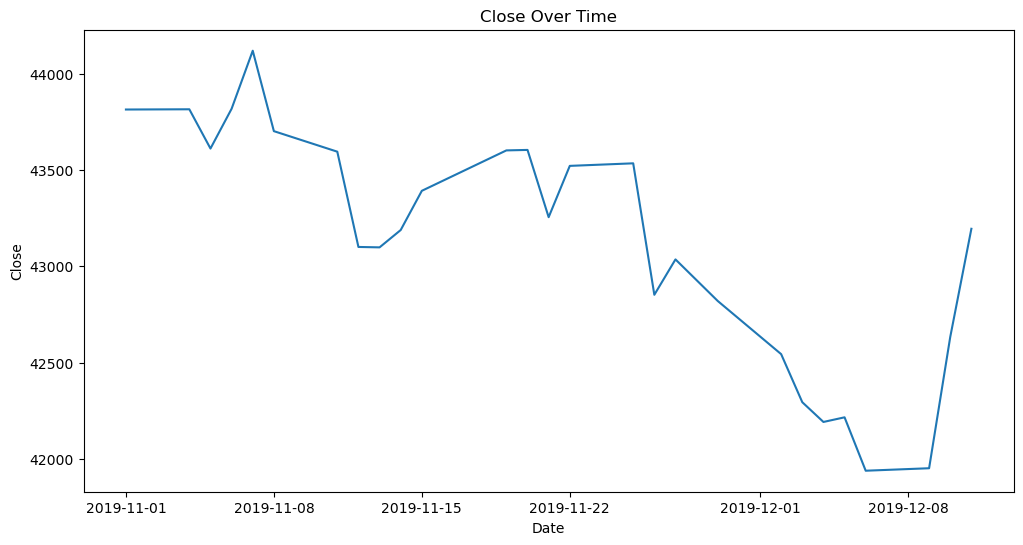

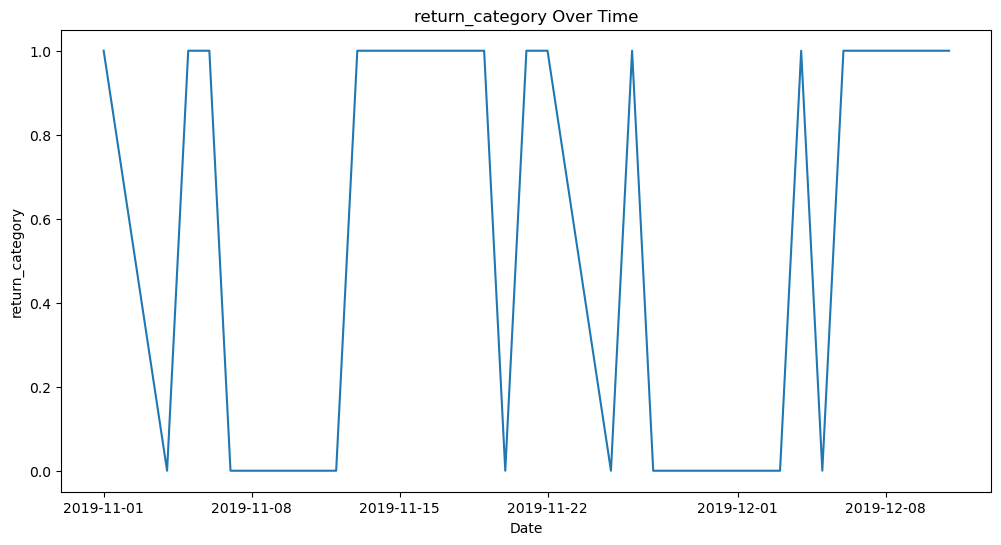

In [18]:
# Plot Validation data

val_df.loc[:, 'Date'] = pd.to_datetime(val_df['Date'], format='%d/%m/%Y')
plot_time_series(val_df, column='Close', plot_yearly=False)
plot_time_series(val_df, column='return_category', plot_yearly=False)

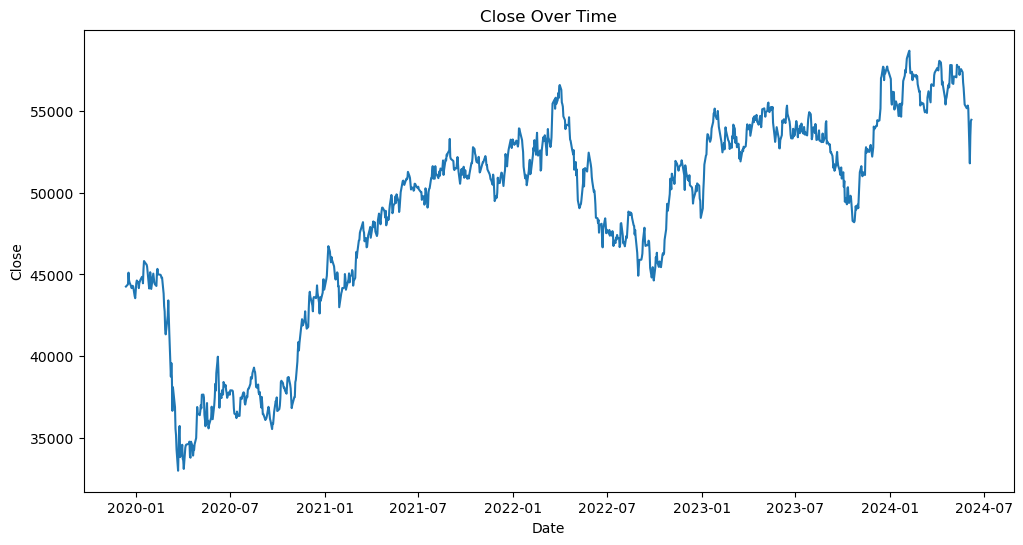

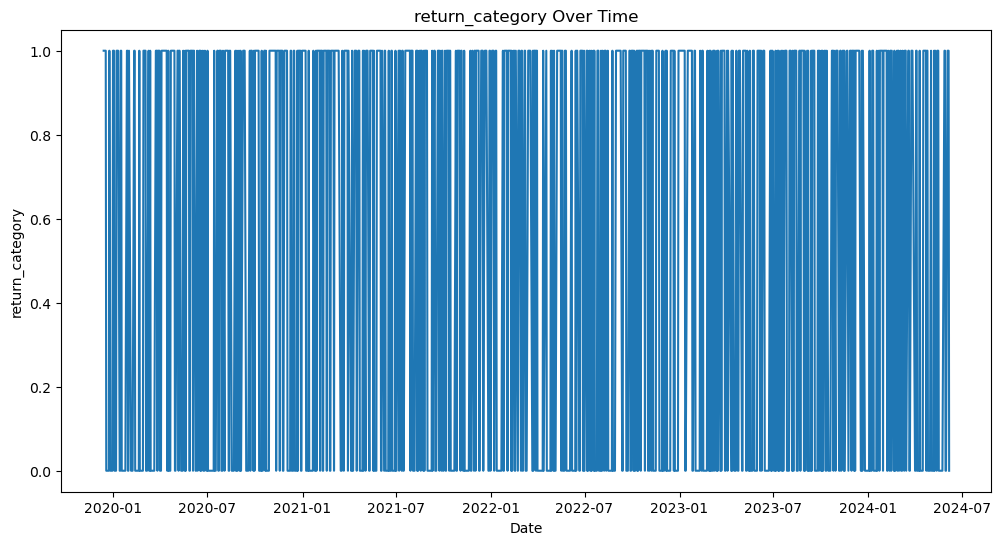

In [19]:
# Plot Test data

test_df.loc[:, 'Date'] = pd.to_datetime(test_df['Date'], format='%d/%m/%Y')
plot_time_series(test_df, column='Close', plot_yearly=False)
plot_time_series(test_df, column='return_category', plot_yearly=False)

# Run PCA Analysis

This PCA resultant components will be used to feed a second version of all models

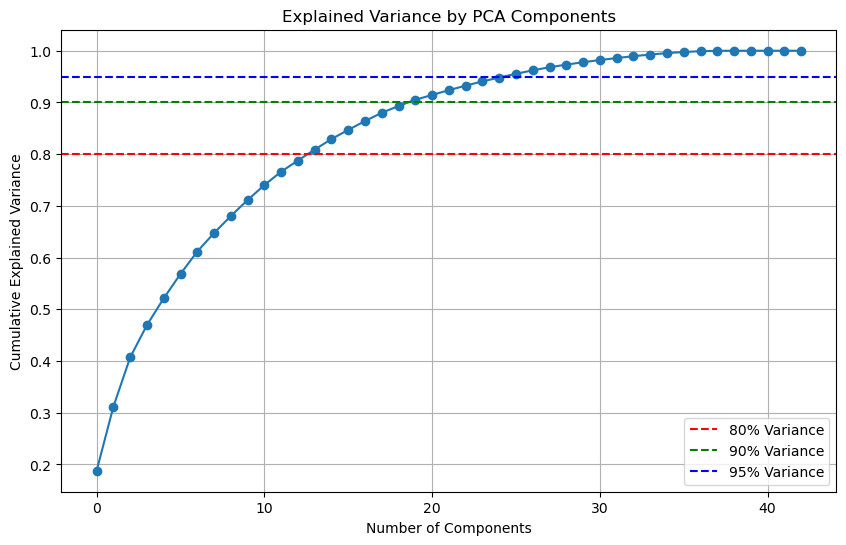

Number of components for 80.0% variance: 14


In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Apply PCA on the Training Set and Determine Explained Variance

# Apply PCA to the scaled training set
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled_df)

# Calculate explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='b', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid()
plt.show()

# Determine the number of components for XX variance
th=0.80
n_components_th = np.argmax(explained_variance >= th) + 1
print(f"Number of components for {th*100}% variance: {n_components_th}")


### Transform PCA components into transformed inputs for models

In [24]:
# Apply PCA with the optimal number of components
pca_optimal = PCA(n_components=n_components_th)
X_train_pca_optimal = pca_optimal.fit_transform(X_train_scaled_df)
X_val_pca_optimal = pca_optimal.transform(X_val_scaled_df)
X_test_pca_optimal = pca_optimal.transform(X_test_scaled_df)

# Create DataFrames for the transformed data
pca_columns = [f'PCA_{i+1}' for i in range(n_components_th)]
train_pca_df = pd.DataFrame(X_train_pca_optimal, columns=pca_columns)
val_pca_df = pd.DataFrame(X_val_pca_optimal, columns=pca_columns)
test_pca_df = pd.DataFrame(X_test_pca_optimal, columns=pca_columns)

# Add the original 'return_category', 'Date', and 'forward_return' columns to each DataFrame
train_pca_df[['return_category', 'Date', 'forward_return']] = train_df[['return_category', 'Date', 'forward_return']].reset_index(drop=True)
val_pca_df[['return_category', 'Date', 'forward_return']] = val_df[['return_category', 'Date', 'forward_return']].reset_index(drop=True)
test_pca_df[['return_category', 'Date', 'forward_return']] = test_df[['return_category', 'Date', 'forward_return']].reset_index(drop=True)


# Features reduction - based on Random Forest model 
#### (this reduced dataset will be used as 3rd alternative to all models)

In [26]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Define the Random Forest model for RFE
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Number of features to select
features_to_select = 15

# Perform RFE
rfe = RFE(rf_model, n_features_to_select=features_to_select)
rfe.fit(X_train_scaled_df, y_train)

# Get selected and removed features
selected_features = X_train_scaled_df.columns[rfe.support_]
removed_features = X_train_scaled_df.columns[~rfe.support_]

# Rank features by importance in the final model
final_rf_model = rf_model.fit(X_train_scaled_df[selected_features], y_train)
feature_importances = pd.DataFrame({
    'feature': selected_features,
    'importance': final_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Get the ranking of removed features (the lower the rank, the later it was removed)
ranking = pd.DataFrame({
    'feature': X_train_scaled_df.columns,
    'ranking': rfe.ranking_
}).sort_values(by='ranking', ascending=True)
dropped_features = ranking[~ranking['feature'].isin(selected_features)]

In [27]:
# Manually add some features

# Define the feature to add manually
additional_feature = ' VIX '

# Add the feature to the selected features list if it's not already in the list
if additional_feature not in selected_features:
    selected_features = selected_features.tolist()  # Ensure it's a list
    selected_features.append(additional_feature)
    selected_features = pd.Index(selected_features)  # Convert back to Index if needed

selected_features

Index(['FX', 'FX_ch%_1d', 'FX_ch%_2d', 'FX_ch%_5d', 'TIIE_ch_20d',
       'Simple_return_1', 'Lagged_Return_1_1', 'Lagged_Return_1_2',
       'Lagged_Return_1_3', 'Lagged_Return_1_5', 'Lagged_Return_1_10', 'OBV',
       'OBV_Change_5', 'OBV_Change_10', 'PVO_12_26', ' VIX '],
      dtype='object')

In [28]:
# Rebuild the train, validation, and test sets with the selected features
train_rfe_df = pd.DataFrame(X_train_scaled_df[selected_features], columns=selected_features)
val_rfe_df = pd.DataFrame(X_val_scaled_df[selected_features], columns=selected_features)
test_rfe_df = pd.DataFrame(X_test_scaled_df[selected_features], columns=selected_features)

# Add the original 'return_category', 'Date', and 'forward_return' columns to each DataFrame
train_rfe_df[['return_category', 'Date', 'forward_return']] = train_df[['return_category', 'Date', 'forward_return']]
val_rfe_df[['return_category', 'Date', 'forward_return']] = val_df[['return_category', 'Date', 'forward_return']]
test_rfe_df[['return_category', 'Date', 'forward_return']] = test_df[['return_category', 'Date', 'forward_return']]

# Display the table of selected features
print("Selected Features:")
display(feature_importances)

# Display the table of removed features
print("Removed Features (larger ranks were removed first):")
display(dropped_features)

Selected Features:


,feature,importance
11,OBV,0.069627
1,FX_ch%_1d,0.068905
5,Simple_return_1,0.068453
10,Lagged_Return_1_10,0.067552
3,FX_ch%_5d,0.067369
7,Lagged_Return_1_2,0.066908
12,OBV_Change_5,0.066905
6,Lagged_Return_1_1,0.066815
8,Lagged_Return_1_3,0.066587
14,PVO_12_26,0.066336


Removed Features (larger ranks were removed first):


,feature,ranking
22,Lagged_Return_5_3,2
40,Chaikin_Oscillator_5_15,3
32,ADX_28,4
6,VIX_ch_1d,5
8,TIIE,6
23,Lagged_Return_5_5,7
24,Lagged_Return_5_10,8
0,Volume,9
39,CLV,10
25,Lagged_Return_10_1,11


# *START CLASSIFICATION MODELING*

In [48]:
# Define the empty DataFrame for best models results
tresults_df = pd.DataFrame(columns=['Model', 'Test Accuracy', 'Test Class 0 Positives %', 'Test Class 1 Positives %', 'Train Time','Final_Investment','Annu_Return','Std_dev_Return','Sharpe'])

# Activation of short/long Param Grid
# This is parameter is looking to reduce the running time of the whole notebook.
# Long=1, Short=0

LongParamGrid = 0



# Generic Train and model validation functions

In [51]:
def train_and_validate_model(train_df, val_df, model):
    # Split features and target variable, excluding 'return_category', 'Date', and 'forward_return'
    X_train = train_df.drop(columns=['return_category', 'Date', 'forward_return'])
    y_train = train_df['return_category']
    X_val = val_df.drop(columns=['return_category', 'Date', 'forward_return'])
    y_val = val_df['return_category']
    
    # Fit the model
    model.fit(X_train, y_train)

    # Calculate accuracy on training
    train_predictions = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, train_predictions)
    
    # Calculate metrics on validation
    val_predictions = model.predict(X_val)
    accuracy_val = accuracy_score(y_val, val_predictions)
    conf_matrix = confusion_matrix(y_val, val_predictions)
    report = classification_report(y_val, val_predictions, target_names=['down', 'N_&_Up'])
 
    return model, accuracy_val, conf_matrix, report, accuracy_train

def train_final_model_and_test(train_df, val_df, test_df, model):
    # Combine training and validation datasets
    final_train_df = pd.concat([train_df, val_df])
    
    # Split features and target variable, excluding 'return_category', 'Date', and 'forward_return'
    X_final_train = final_train_df.drop(columns=['return_category', 'Date', 'forward_return'])
    y_final_train = final_train_df['return_category']
    X_test = test_df.drop(columns=['return_category', 'Date', 'forward_return'])
    y_test = test_df['return_category']
    
    # Fit the final model
    final_model = clone(model)
    start_time = time()
    final_model.fit(X_final_train, y_final_train)
    end_time = time()
    train_time = end_time - start_time

    #Predict
    test_predictions = final_model.predict(X_test)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_conf_matrix = confusion_matrix(y_test, test_predictions)
    test_report = classification_report(y_test, test_predictions, target_names=['down', 'N_&_Up'])
    
    return final_model, test_accuracy, test_conf_matrix, test_report,train_time


# Run Benchmark Metrics of Investment Strategy
Complementary metrics of implementing this buy/sell signal in an investment strategy. Still under improvement but is useful to start comparing models

In [54]:
def investment_strategy_performance(test_df, predictions=None, run_benchmarks=None):
    # Initial investment amount
    investment_amount = 1.0
    investment_values = []
    
    # Record of the strategy returns
    strategy_returns = []
    
    # Create a DataFrame to store results
    results = test_df[['Date', 'Close', 'forward_return', 'return_category']].copy()
    
    if run_benchmarks is not False:
        if run_benchmarks == 1:
            predictions = np.ones(len(test_df))  # Always buy
        elif run_benchmarks == 0:
            predictions = np.zeros(len(test_df))  # Always sell
    elif predictions is None:
        raise ValueError("Predictions must be provided unless run_benchmarks is specified")
    
    results['Prediction'] = predictions
    
    # Calculate the following observation date
    results['Following Date'] = results['Date'].shift(-1)
    results.loc[results.index[-1], 'Following Date'] = results['Date'].iloc[-1] + pd.Timedelta(days=1)
    
    # Iterate through the test set
    for i in range(len(test_df)):
        if predictions[i] == 1:  # Buy signal
            strategy_return = test_df['forward_return'].iloc[i]
        else:  # Sell signal
            tiie_rate = test_df['TIIE'].iloc[i] / 360
            days = (results['Following Date'].iloc[i] - results['Date'].iloc[i]).days
            strategy_return = tiie_rate * days
        
        # Update investment amount
        investment_amount *= (1 + strategy_return)
        
        # Record the strategy return and investment value
        strategy_returns.append(strategy_return)
        investment_values.append(investment_amount)
    
    # Add strategy return and investment values to results DataFrame
    results['Strategy Return'] = strategy_returns
    results['Investment Amount'] = investment_values  # Align with the rest of the data
    
    # Calculate daily excess returns
    results['Excess Return'] = results['Strategy Return'] - (test_df['TIIE'] / 360)
    
    # Calculate metrics
    final_investment_amount = investment_amount
    total_days = (results['Date'].iloc[-1] - results['Date'].iloc[0]).days
    annualized_return = (final_investment_amount) ** (365.0 / total_days) - 1

    # Calculate annualized standard deviation of returns
    std_dev_daily_returns = results['Strategy Return'].std()
    annualized_std_dev = std_dev_daily_returns * np.sqrt(252)

    if run_benchmarks == 0:
        # Always sell benchmark case
        sharpe_ratio = 'N/A'
    else:
        # Calculate annualized excess return
        annualized_excess_return = (1 + results['Excess Return'].mean()) ** 252 - 1
        # Calculate Sharpe ratio using annualized excess return and regular standard deviation
        sharpe_ratio = annualized_excess_return / annualized_std_dev

# Print results
    print(f"Final Investment Amount: ${final_investment_amount:.2f}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Standard Deviation: {annualized_std_dev:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio}")
    
    return results, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio



In [56]:
# Run benchmarks
print("Always Buy Benchmark:")
print("\nFull data:")
results_df_buy, final_investment_amount_buy, annualized_return_buy, annualized_std_dev_buy, sharpe_ratio_buy = investment_strategy_performance(dfm, run_benchmarks=1)

print("\nTrain Set:")
results_df_buy, final_investment_amount_buy, annualized_return_buy, annualized_std_dev_buy, sharpe_ratio_buy = investment_strategy_performance(train_df, run_benchmarks=1)

print("\nVal Set:")
results_df_buy, final_investment_amount_buy, annualized_return_buy, annualized_std_dev_buy, sharpe_ratio_buy = investment_strategy_performance(val_df, run_benchmarks=1)

print("\nTest set:")
results_df_buy, final_investment_amount_buy, annualized_return_buy, annualized_std_dev_buy, sharpe_ratio_buy = investment_strategy_performance(test_df, run_benchmarks=1)

'Final_Investment','Annu_Return','Std_dev_Return','Sharpe'

Always Buy Benchmark:

Full data:
Final Investment Amount: $8.16
Annualized Return: 10.05%
Annualized Standard Deviation: 18.82%
Sharpe Ratio: 0.3921671201369989

Train Set:
Final Investment Amount: $6.75
Annualized Return: 11.65%
Annualized Standard Deviation: 19.01%
Sharpe Ratio: 0.48864605563036684

Val Set:
Final Investment Amount: $1.01
Annualized Return: 9.54%
Annualized Standard Deviation: 13.63%
Sharpe Ratio: 0.35480967931973095

Test set:
Final Investment Amount: $1.20
Annualized Return: 4.09%
Annualized Standard Deviation: 18.18%
Sharpe Ratio: 0.021241416173656862


('Final_Investment', 'Annu_Return', 'Std_dev_Return', 'Sharpe')

In [58]:
# Run benchmarks
print("Always Sell Benchmark:")
print("\nFull data:")
results_df_sell, final_investment_amount_sell, annualized_return_sell, annualized_std_dev_sell, sharpe_ratio_sell = investment_strategy_performance(dfm, run_benchmarks=0)

print("\nTrain Set:")
results_df_sell, final_investment_amount_sell, annualized_return_sell, annualized_std_dev_sell, sharpe_ratio_sell = investment_strategy_performance(train_df, run_benchmarks=0)

print("\nVal Set:")
results_df_sell, final_investment_amount_sell, annualized_return_sell, annualized_std_dev_sell, sharpe_ratio_sell = investment_strategy_performance(val_df, run_benchmarks=0)

print("\nTest set:")
results_df_sell, final_investment_amount_sell, annualized_return_sell, annualized_std_dev_sell, sharpe_ratio_sell = investment_strategy_performance(test_df, run_benchmarks=0)



Always Sell Benchmark:

Full data:
Final Investment Amount: $4.35
Annualized Return: 6.93%
Annualized Standard Deviation: 0.33%
Sharpe Ratio: N/A

Train Set:
Final Investment Amount: $3.02
Annualized Return: 6.60%
Annualized Standard Deviation: 0.31%
Sharpe Ratio: N/A

Val Set:
Final Investment Amount: $1.01
Annualized Return: 8.50%
Annualized Standard Deviation: 0.32%
Sharpe Ratio: N/A

Test set:
Final Investment Amount: $1.43
Annualized Return: 8.22%
Annualized Standard Deviation: 0.41%
Sharpe Ratio: N/A


# Benchmark Accuracy parameters

Reference metrics of 'what if' the models always predict Buy or Sell

In [60]:
# Benchmark
print("BENCHMARK ACCURACIES")
print(" ")
print("TRAIN SET")
print("--------------")
print(f'Only Buy Accuracy: {train_counts[1]/train_counts.sum()} & Only Sell Accuracy: {train_counts[0]/train_counts.sum()}')
print(" ")
print("VALIDATION SET")
print("--------------")
print(f'Only Buy Accuracy: {val_counts[1]/val_counts.sum()} & Only Sell Accuracy: {val_counts[0]/val_counts.sum()}')
print(" ")
print("TEST SET")
print("--------------")
print(f'Only Buy Accuracy: {test_counts[1]/test_counts.sum()} & Only Sell Accuracy: {test_counts[0]/test_counts.sum()}')

#Add Benchmark data to the final results table as  reference
model_name="Always Buy -Ref-"
# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_counts[1]/test_counts.sum() * 100,
    'Test Class 0 Positives %': 0,
    'Test Class 1 Positives %': 100,
    'Train Time': 0.0,
    'Final_Investment': final_investment_amount_buy,
    'Annu_Return': annualized_return_buy,
    'Std_dev_Return': annualized_std_dev_buy,
    'Sharpe': sharpe_ratio_buy
}])
# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

model_name="Always Sell -Ref-"
# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_counts[0]/test_counts.sum() * 100,
    'Test Class 0 Positives %': 100,
    'Test Class 1 Positives %': 0,
    'Train Time': 0.0,
    'Final_Investment': final_investment_amount_sell,
    'Annu_Return': annualized_return_sell,
    'Std_dev_Return': annualized_std_dev_sell,
    'Sharpe': sharpe_ratio_sell
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)


BENCHMARK ACCURACIES
 
TRAIN SET
--------------
Only Buy Accuracy: 0.5331900668576887 & Only Sell Accuracy: 0.46680993314231134
 
VALIDATION SET
--------------
Only Buy Accuracy: 0.5555555555555556 & Only Sell Accuracy: 0.4444444444444444
 
TEST SET
--------------
Only Buy Accuracy: 0.5041398344066237 & Only Sell Accuracy: 0.49586016559337626


# RANDOM FOREST

# Model 1.1: Random Forest with all features

In [476]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, StratifiedKFold

from time import time

In [477]:
# Function for manual grid search with time series split
'''For all models, i'm doing a Cross validation applied to time series (to avoid future data contamination) to calibrate 
hyperparameters and avoid/minimize overfitting and ensure a healthy behavior in out of sample data'''

def manual_grid_search_time_series_cv(train_df, param_grid, n_splits=5):
    X = train_df.drop(columns=['return_category', 'Date', 'forward_return'])
    y = train_df['return_category']

    resultss = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Calculate total number of parameter combinations
    total_combinations = np.prod([len(values) for values in param_grid.values()])
    
    for i, params in enumerate(ParameterGrid(param_grid)):
        model = RandomForestClassifier(**params, random_state=42, class_weight='balanced')
        cv_scores = []

        for train_index, val_index in tscv.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            model.fit(X_train, y_train)
            val_predictions = model.predict(X_val)
            accuracy_val = accuracy_score(y_val, val_predictions)
            cv_scores.append(accuracy_val)

        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        model.fit(X, y)
        train_predictions = model.predict(X)
        accuracy_train = accuracy_score(y, train_predictions)

        resultss.append({
            'params': params,
            'train_accuracy': accuracy_train,
            'cv_mean_accuracy': mean_cv_score,
            'cv_std_accuracy': std_cv_score
        })

        # Iteratively print the status
        clear_output(wait=True)
        print(f"Finished process {i+1} of a total of {total_combinations} combinations")

    # Clear the display before the final print
    clear_output(wait=True)
    
    results_dff = pd.DataFrame(resultss)
    results_dff = results_dff.sort_values(by='cv_mean_accuracy', ascending=False)

    best_params = results_dff.iloc[0]['params']
    best_score = results_dff.iloc[0]['cv_mean_accuracy']
    best_model = RandomForestClassifier(**best_params, random_state=42)
    best_model.fit(X, y)

    pd.set_option('display.max_colwidth', 150)
    print("Top 10 hyperparameter combinations based on cross-validation accuracy:")
    display(results_dff[['cv_mean_accuracy', 'cv_std_accuracy', 'train_accuracy', 'params']].head(10))

    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score}")

    return best_model, best_params, best_score, results_dff

### Run Grid search for optimal parameters

In [479]:
# IDENTIFY THE BEST PARAMETERS AVOIDING OVERFITTING

if LongParamGrid==1:
    param_grid = {
    'n_estimators': [20,50,100], #100,200 discarded
    'max_depth': [5,10,20], #30 discarded 
    'min_samples_split': [5,10,15], #10 discarded
    'min_samples_leaf': [3,5,7],
    'max_features': ['sqrt'], #['auto', 'sqrt', 'log2'],
    'criterion': ['entropy'] #'gini and entropy'
    }
else:
    param_grid = {
    'n_estimators': [20,50,100], 
    'max_depth': [5,10],  
    'min_samples_split': [10,20],
    'min_samples_leaf': [3,5],
    'max_features': ['sqrt'],
    'criterion': ['entropy'] 
    }



In [480]:
# Call the grid search function
best_rf_model, best_params, best_val_score, results_df = manual_grid_search_time_series_cv(train_scaled_df, param_grid)

Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
67,0.523496,0.017490,0.998567,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}"
64,0.523496,0.017490,0.998567,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}"
78,0.520344,0.013452,0.955110,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 20}"
40,0.519771,0.011440,0.886342,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}"
37,0.519771,0.011440,0.886342,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}"
58,0.518911,0.006105,0.998329,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}"
39,0.518625,0.021878,0.831423,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}"
36,0.518625,0.021878,0.831423,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 20}"
28,0.517765,0.008625,0.895177,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}"
80,0.517765,0.025283,0.995941,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}"


Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-Validation Score: 0.5234957020057307


In [481]:
# Evaluate the best model on the validation set
'''final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_scaled_df, val_scaled_df, best_rf_model)

print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")'''

'final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_scaled_df, val_scaled_df, best_rf_model)\n\nprint("----------------------------")\nprint(f"Final Model Train Accuracy: {accuracy_train}")\nprint(f"Final Model Validation Accuracy: {accuracy_val}")\nprint("----------------------------")\nprint(f"Validation Confusion Matrix:\n{conf_matrix}")\nprint(f"Validation Classification Report:\n{report}")'

In [482]:
# Train final model and test
final_rf_model, test_accuracy, test_conf_matrix, test_report, train_time = train_final_model_and_test(train_scaled_df, val_scaled_df, test_scaled_df, best_rf_model)

print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")



----------------------------
Test Accuracy: 0.5188592456301748
Training Time: 2.2186481952667236 seconds
----------------------------
Test Confusion Matrix:
[[249 290]
 [233 315]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.52      0.46      0.49       539
      N_&_Up       0.52      0.57      0.55       548

    accuracy                           0.52      1087
   macro avg       0.52      0.52      0.52      1087
weighted avg       0.52      0.52      0.52      1087



In [483]:
predictions_B = best_rf_model.predict(test_scaled_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.18
Annualized Return: 3.77%
Annualized Standard Deviation: 14.32%
Sharpe Ratio: -0.03904885847450882


In [484]:
model_name="Random Forest - ALL Inputs"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

### Additional results analysis

In [486]:
# Assuming the model is already fitted and X_train is the DataFrame used for training
feature_importances = pd.DataFrame(best_rf_model.feature_importances_,
                                   index=X_train_scaled_df.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


                         importance
Lagged_Return_1_3          0.027414
Lagged_Return_10_1         0.026693
FX_ch%_5d                  0.026506
FX_ch%_2d                  0.026013
Lagged_Return_1_5          0.025993
FX_ch%_1d                  0.025322
Simple_return_1            0.025295
OBV_Change_5               0.024985
OBV_Change_1               0.024722
Lagged_Return_10_10        0.024701
Simple_return_2            0.024035
Chaikin_Oscillator_5_15    0.023965
TIIE_ch_20d                0.023892
CLV                        0.023876
VIX_ch_1d                  0.023830
Lagged_Return_10_5         0.023818
 VIX                       0.023773
VIX_ch_5d                  0.023604
OBV                        0.023596
Lagged_Return_1_2          0.023442
Lagged_Return_1_10         0.023411
PVO_12_26                  0.023229
std_dev_return_10          0.023184
Lagged_Return_5_3          0.022987
TIIE                       0.022886
Lagged_Return_5_5          0.022842
Lagged_Return_5_10         0

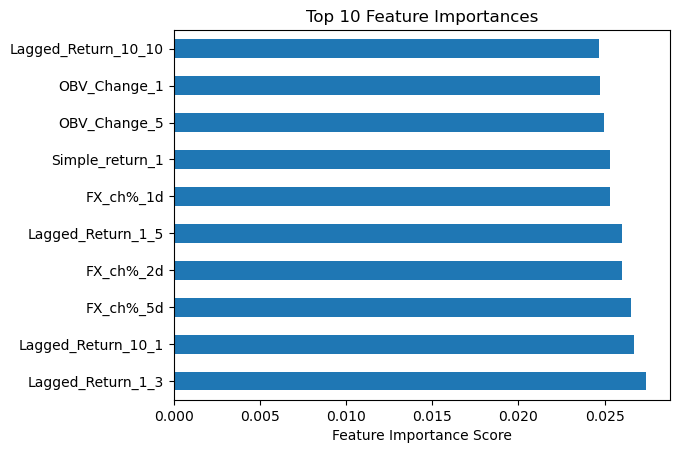

In [487]:
# Plot feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train_scaled_df.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Feature Importances')
plt.show()

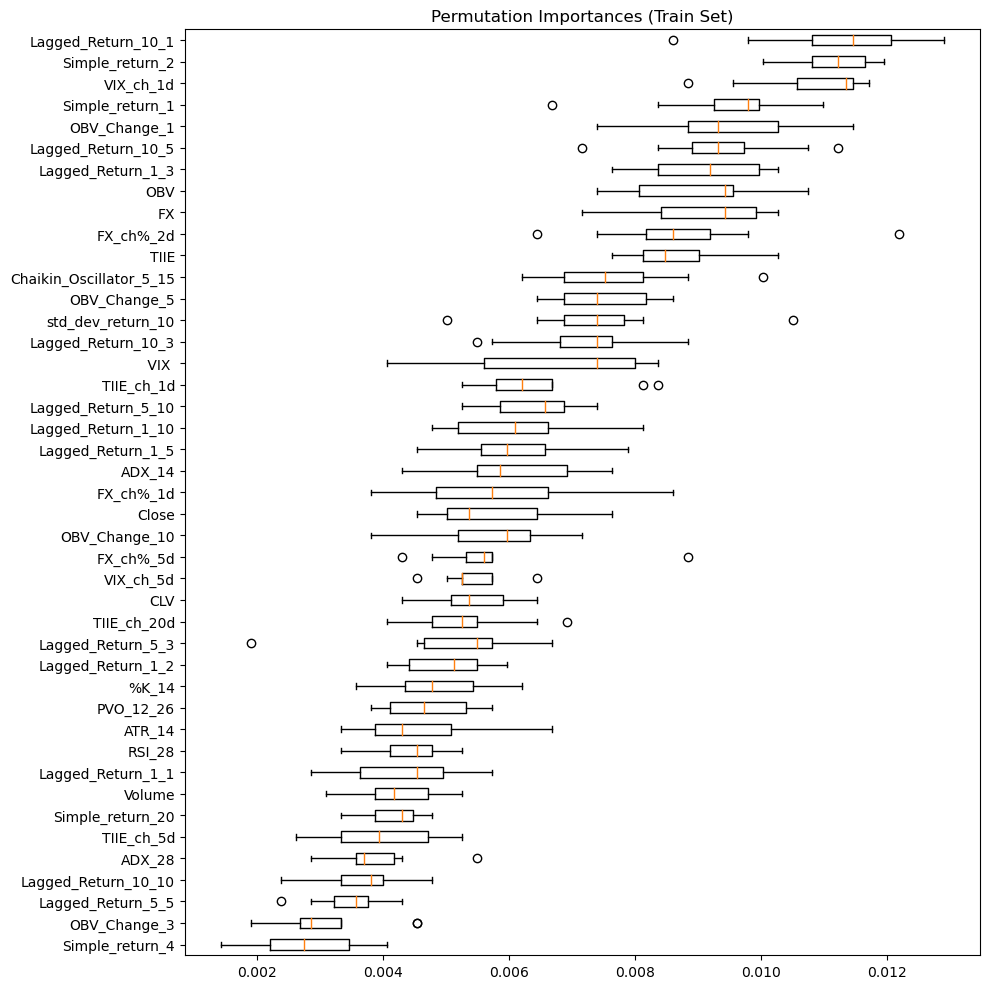

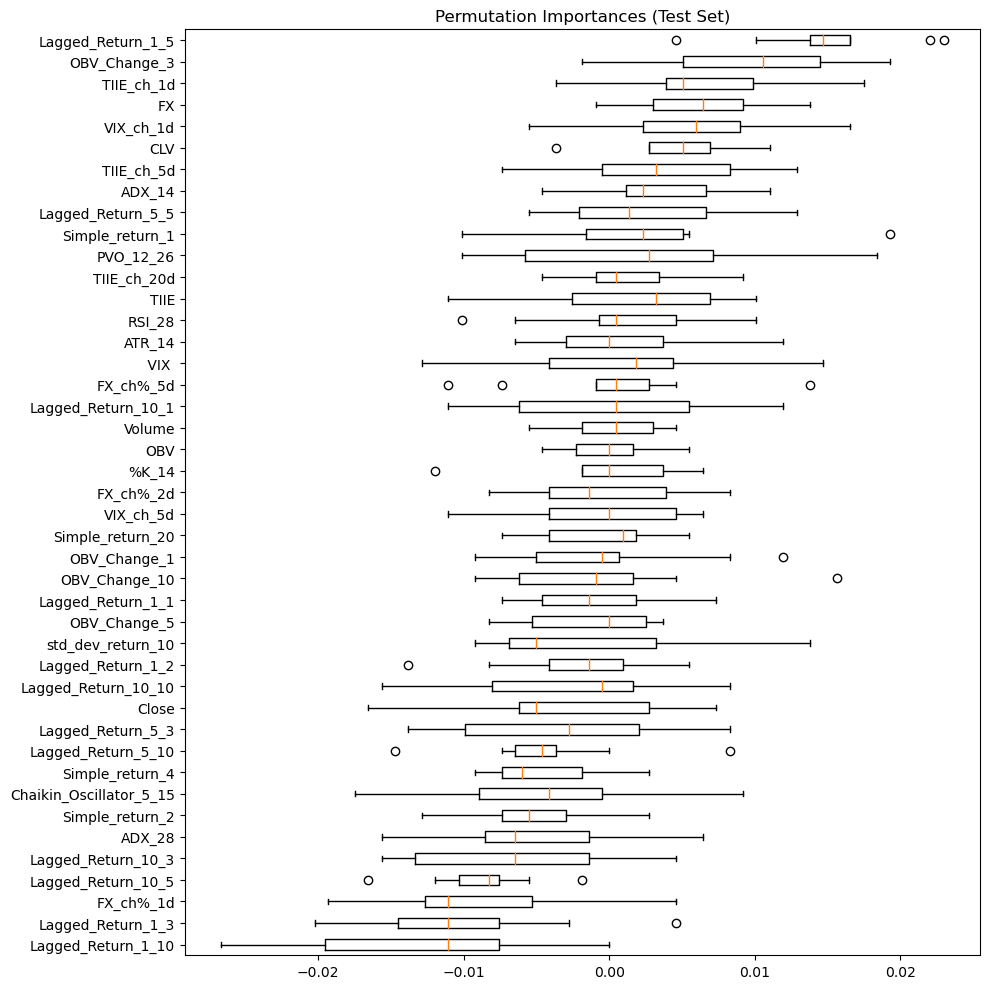

In [488]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Convert scaled data back to DataFrame to ensure feature names are preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled_df, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled_df, columns=X_test.columns)

# Calculate permutation importance on the training set
result_train = permutation_importance(estimator=best_rf_model, X=X_train_scaled_df, y=y_train, n_repeats=10, random_state=1, n_jobs=2)

# Calculate permutation importance on the validation set
result_test = permutation_importance(estimator=best_rf_model, X=X_test_scaled_df, y=y_test, n_repeats=10, random_state=1, n_jobs=2)

# Sort the features by their importance values (mean)
sorted_idx_train = result_train.importances_mean.argsort()
sorted_idx_test = result_test.importances_mean.argsort()

# Function to plot permutation importances
def plot_perm_importance(result, sorted_idx, feature_names, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

# Convert feature names to a NumPy array for indexing
feature_names = np.array(X_train_scaled_df.columns)

# Plot permutation importances for the training set
plot_perm_importance(result_train, sorted_idx_train, feature_names, "Permutation Importances (Train Set)")

# Plot permutation importances for the validation set
plot_perm_importance(result_test, sorted_idx_test, feature_names, "Permutation Importances (Test Set)")

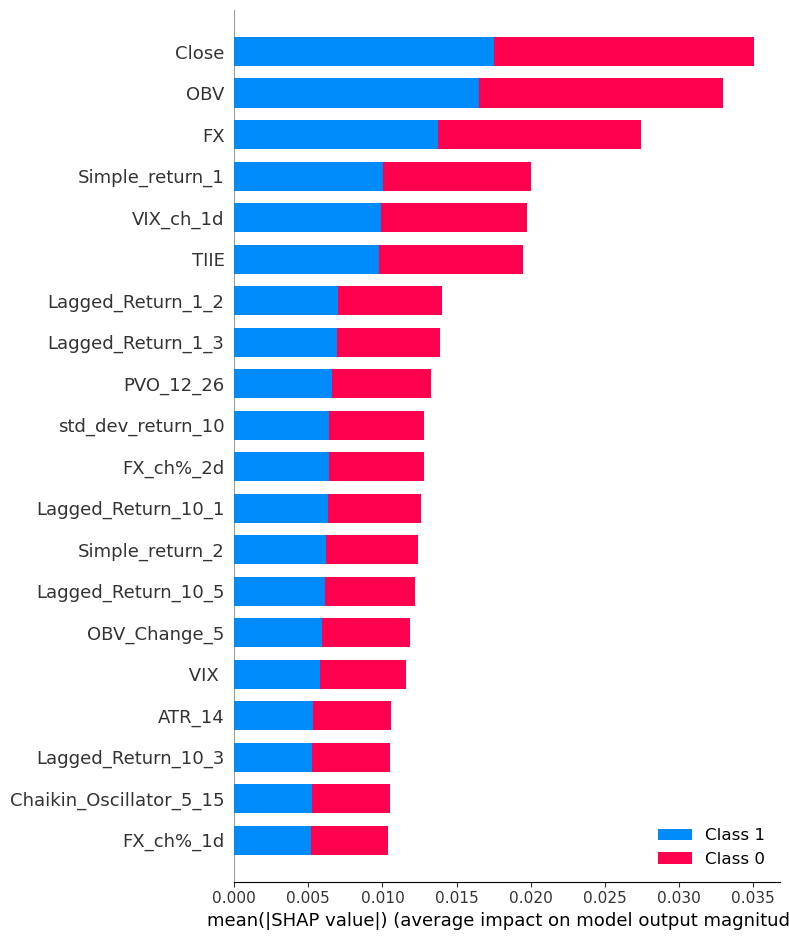

In [489]:
import shap

# Make sure your DataFrame columns have the correct feature names
X_test_df = pd.DataFrame(X_test_scaled_df, columns=X_train.columns)

# Create the SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_df)

# Create the summary plot
shap.summary_plot(shap_values, X_test_df, feature_names=X_test_df.columns)

# Optionally, you can also plot SHAP dependence and other plots
# shap.dependence_plot("FeatureName", shap_values, X_test_df)

forward_return_bucket
-0.01 to 0.0      374
0.0 to 0.01       364
0.01 to 0.02      141
-0.02 to -0.01    129
0.02 to 0.03       35
-0.03 to -0.02     26
0.03 to 0.04        7
-0.04 to -0.03      5
-0.07 to -0.06      3
-0.06 to -0.05      2
0.04 to 0.05        1
-0.05 to -0.04      0
0.05 to 0.06        0
0.06 to 0.07        0
0.07 to 0.08        0
Name: count, dtype: int64
   Forward Return Bucket  Prediction Accuracy
0         -0.07 to -0.06             1.000000
1         -0.06 to -0.05             0.500000
2         -0.05 to -0.04                  NaN
3         -0.04 to -0.03             0.600000
4         -0.03 to -0.02             0.615385
5         -0.02 to -0.01             0.480620
6           -0.01 to 0.0             0.497326
7            0.0 to 0.01             0.513736
8           0.01 to 0.02             0.524823
9           0.02 to 0.03             0.571429
10          0.03 to 0.04             0.285714
11          0.04 to 0.05                  NaN
12          0.05 to 0.06

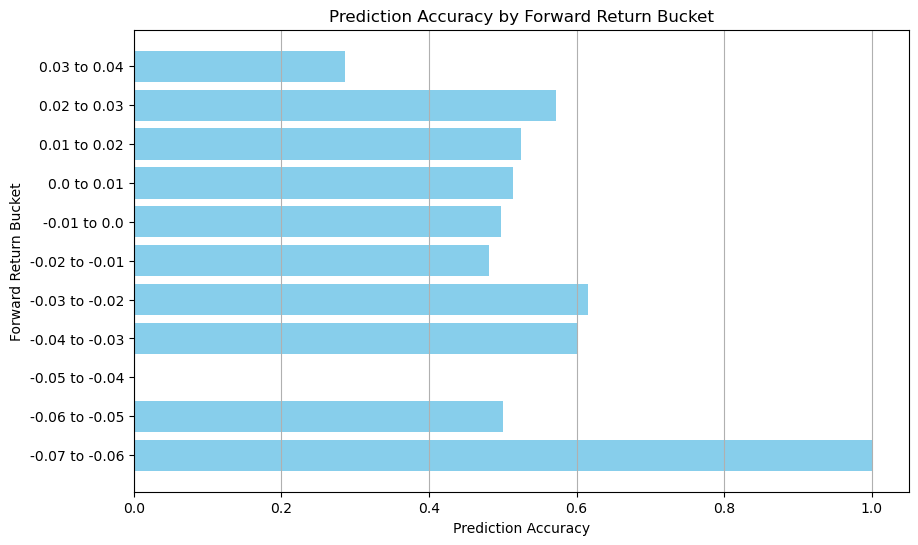

In [490]:
# Create a copy of the test DataFrame to ensure the original is not altered
test_df_copy = test_df.copy()

# Define bins for forward_return in steps of 0.50%
bins = np.arange(-0.07, 0.07 + 0.01, 0.01)
labels = [f"{round(b, 3)} to {round(b + 0.01, 3)}" for b in bins[:-1]]
test_df_copy['forward_return_bucket'] = pd.cut(test_df_copy['forward_return'], bins=bins, labels=labels, include_lowest=True)

# Verify the distribution of samples in each bucket
bucket_counts = test_df_copy['forward_return_bucket'].value_counts()
print(bucket_counts)

# Filter out buckets with very small values or null
min_samples_per_bucket = 2
valid_buckets = bucket_counts[bucket_counts >= min_samples_per_bucket].index
filtered_test_df = test_df_copy[test_df_copy['forward_return_bucket'].isin(valid_buckets)].copy()

# Get model predictions for the test set
test_predictions = best_rf_model.predict(X_test_scaled_df)

# Ensure filtered_test_df and test_predictions are aligned
filtered_test_df = filtered_test_df.iloc[:len(test_predictions)].copy()

# Add predictions and true labels to the test DataFrame
filtered_test_df['predictions'] = test_predictions[:len(filtered_test_df)]
filtered_test_df['true_labels'] = y_test[:len(filtered_test_df)].values

# Calculate accuracy within each bucket
bucket_accuracy = filtered_test_df.groupby('forward_return_bucket').apply(lambda x: (x['predictions'] == x['true_labels']).mean())

# Generate a summary report
report = bucket_accuracy.reset_index()
report.columns = ['Forward Return Bucket', 'Prediction Accuracy']

# Display the report
print(report)

# Optionally, plot the results for better visualization
plt.figure(figsize=(10, 6))
plt.barh(report['Forward Return Bucket'], report['Prediction Accuracy'], color='skyblue')
plt.xlabel('Prediction Accuracy')
plt.ylabel('Forward Return Bucket')
plt.title('Prediction Accuracy by Forward Return Bucket')
plt.grid(axis='x')
plt.show()

# Model 1.2: Random Forest with PCA vectors as inputs

In [492]:
# IDENTIFY THE BEST PARAMETERS AVOIDING OVERFITTING

# Call the grid search function
best_rf_model, best_params, best_val_score, results_df = manual_grid_search_time_series_cv(train_pca_df, param_grid)

Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
35,0.532665,0.018732,0.864852,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 100}"
7,0.528653,0.026370,0.668099,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 50}"
8,0.526934,0.019421,0.685291,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 100}"
26,0.525501,0.017202,0.678844,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}"
61,0.524642,0.021025,0.989733,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 50}"
44,0.523782,0.020029,0.857211,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 100}"
62,0.522636,0.028036,0.995463,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 100}"
2,0.521777,0.025747,0.674546,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}"
23,0.521777,0.013143,0.681232,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}"
20,0.521777,0.013143,0.681232,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 100}"


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 100}
Best Cross-Validation Score: 0.5326647564469914


In [493]:
# Evaluate the best model using the existing train_and_validate_model function
final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_pca_df, val_pca_df, best_rf_model)

# Print final results
print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.8326170009551098
Final Model Validation Accuracy: 0.7037037037037037
----------------------------
Validation Confusion Matrix:
[[ 7  5]
 [ 3 12]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.70      0.58      0.64        12
      N_&_Up       0.71      0.80      0.75        15

    accuracy                           0.70        27
   macro avg       0.70      0.69      0.69        27
weighted avg       0.70      0.70      0.70        27



In [494]:
# Train final model and test
final_rf_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_model_and_test(train_pca_df, val_pca_df, test_pca_df, best_rf_model)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5225390984360626
Training Time: 2.782747983932495 seconds
----------------------------
Test Confusion Matrix:
[[175 364]
 [155 393]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.53      0.32      0.40       539
      N_&_Up       0.52      0.72      0.60       548

    accuracy                           0.52      1087
   macro avg       0.52      0.52      0.50      1087
weighted avg       0.52      0.52      0.50      1087



In [495]:
predictions_B = best_rf_model.predict(test_pca_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.60
Annualized Return: 11.11%
Annualized Standard Deviation: 14.78%
Sharpe Ratio: 0.46222265921968636


In [496]:
model_name="Random Forest - PCA"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 1.3: Random Forest with Reduced features

In [498]:
# IDENTIFY THE BEST PARAMETERS AVOIDING OVERFITTING

# Call the grid search function
best_rf_model, best_params, best_val_score, results_df = manual_grid_search_time_series_cv(train_rfe_df, param_grid)

Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
63,0.516332,0.018759,0.969914,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 20}"
66,0.516332,0.018759,0.969914,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}"
49,0.513754,0.023324,0.851958,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 50}"
46,0.513754,0.023324,0.851958,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 50}"
60,0.512321,0.024956,0.956065,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 20}"
61,0.510029,0.030297,0.984718,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 50}"
15,0.508883,0.024337,0.624881,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 20}"
70,0.507450,0.026314,0.981375,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 50}"
55,0.507163,0.023012,0.997851,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}"
57,0.506877,0.019484,0.973734,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 20}"


Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 20}
Best Cross-Validation Score: 0.5163323782234956


In [499]:
# Evaluate the best model using the existing train_and_validate_model function
final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_rfe_df, val_rfe_df, best_rf_model)

# Print final results
print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.9610792741165234
Final Model Validation Accuracy: 0.4444444444444444
----------------------------
Validation Confusion Matrix:
[[10  2]
 [13  2]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.43      0.83      0.57        12
      N_&_Up       0.50      0.13      0.21        15

    accuracy                           0.44        27
   macro avg       0.47      0.48      0.39        27
weighted avg       0.47      0.44      0.37        27



In [500]:
# Train final model and test
final_rf_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_model_and_test(train_rfe_df, val_rfe_df, test_rfe_df, best_rf_model)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5197792088316467
Training Time: 0.5605461597442627 seconds
----------------------------
Test Confusion Matrix:
[[267 272]
 [250 298]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.52      0.50      0.51       539
      N_&_Up       0.52      0.54      0.53       548

    accuracy                           0.52      1087
   macro avg       0.52      0.52      0.52      1087
weighted avg       0.52      0.52      0.52      1087



In [501]:
predictions_B = best_rf_model.predict(test_rfe_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.84
Annualized Return: 14.58%
Annualized Standard Deviation: 14.24%
Sharpe Ratio: 0.7171830688851683


In [502]:
model_name="Random Forest - Reduced features"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

### Additional results analysis

In [504]:
# Extract feature importances
feature_importances = pd.DataFrame({
    'feature': train_rfe_df.drop(columns=['return_category', 'Date', 'forward_return']).columns,
    'importance': final_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Print the sorted list of features and their importances
print("Sorted List of Features and Their Importances:")

# Optionally, display the DataFrame for a better view
display(feature_importances)

Sorted List of Features and Their Importances:


,feature,importance
11,OBV,0.071932
5,Simple_return_1,0.070458
7,Lagged_Return_1_2,0.065544
4,TIIE_ch_20d,0.064732
13,OBV_Change_10,0.064200
14,PVO_12_26,0.064011
9,Lagged_Return_1_5,0.063898
6,Lagged_Return_1_1,0.063874
3,FX_ch%_5d,0.062487
1,FX_ch%_1d,0.060630


# LOGISTIC REGRESSION

# Model 2.1: Logistic regression model

In [507]:
from sklearn.linear_model import LogisticRegression


In [508]:
def manual_grid_search_logistic_cv(train_df, param_grid, n_splits=5):
    # Extract features and target
    X_train = train_df.drop(columns=['return_category', 'Date', 'forward_return'])
    y_train = train_df['return_category']

    resultss = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Calculate total number of parameter combinations
    total_combinations = np.prod([len(values) for values in param_grid.values()])
    
    for i, params in enumerate(ParameterGrid(param_grid)):
        try:
            model = LogisticRegression(**params, random_state=42, max_iter=1000)
            cv_scores = []

            for train_index, val_index in tscv.split(X_train):
                X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

                model.fit(X_train_cv, y_train_cv)
                val_predictions = model.predict(X_val_cv)
                accuracy_val = accuracy_score(y_val_cv, val_predictions)
                cv_scores.append(accuracy_val)

            mean_cv_score = np.mean(cv_scores)
            std_cv_score = np.std(cv_scores)

            model.fit(X_train, y_train)
            train_predictions = model.predict(X_train)
            accuracy_train = accuracy_score(y_train, train_predictions)

            resultss.append({
                'params': params,
                'train_accuracy': accuracy_train,
                'cv_mean_accuracy': mean_cv_score,
                'cv_std_accuracy': std_cv_score
            })
        except ValueError as e:
            print(f"Skipping parameters {params} due to error: {e}")

        # Iteratively print the status
        clear_output(wait=True)
        print(f"Finished process {i+1} of a total of {total_combinations} combinations")

    # Clear the display before the final print
    clear_output(wait=True)

    results_dff = pd.DataFrame(resultss)
    results_dff = results_dff.sort_values(by='cv_mean_accuracy', ascending=False)

    best_params = results_dff.iloc[0]['params']
    best_score = results_dff.iloc[0]['cv_mean_accuracy']
    best_model = LogisticRegression(**best_params, random_state=42, max_iter=1000)
    best_model.fit(X_train, y_train)

    pd.set_option('display.max_colwidth', 150)
    print("Top 10 hyperparameter combinations based on cross-validation accuracy:")
    display(results_dff[['cv_mean_accuracy', 'cv_std_accuracy', 'train_accuracy', 'params']].head(10))

    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score}")

    return best_model, best_params, best_score, results_dff

### Run Grid search for optimal parameters

In [510]:
# IDENTIFY THE BEST PARAMETERS AVOIDING OVERFITTING

if LongParamGrid==1:
    param_grid = {
    'penalty': ['l2'],
    'C': [.0001, .001, 0.01, 0.1],
    'solver': ['lbfgs','liblinear'],
    'class_weight': [None, 'balanced']
    }
else:
    param_grid = {
    'penalty': ['l2'],
    'C': [.0001, .001],
    'solver': ['lbfgs'],
    }

#param_grid = [
#    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'class_weight': ['balanced']},
#    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear', 'saga'], 'class_weight': ['balanced']},
#    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'class_weight': ['balanced'], 'l1_ratio': [0.5]},
#    {'penalty': ['None'], 'solver': ['lbfgs', 'saga'], 'class_weight': ['balanced']}
#]

In [511]:
# Call the grid search function with time series cross-validation
best_logistic_model, best_params, best_cv_score, results_df = manual_grid_search_logistic_cv(train_scaled_df, param_grid)


Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
12,0.539542,0.035228,0.552770,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
8,0.531519,0.027706,0.553247,"{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
0,0.530372,0.030813,0.534623,"{'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
4,0.528367,0.037517,0.542980,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
13,0.526934,0.022605,0.552531,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
14,0.525788,0.030065,0.552531,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}"
10,0.522063,0.029550,0.546562,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}"
5,0.520917,0.026581,0.552053,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
1,0.520057,0.019789,0.545368,"{'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
2,0.518338,0.018863,0.538204,"{'C': 0.0001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}"


Best Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.539541547277937


In [512]:
# Evaluate the best model using the existing train_and_validate_model function

final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_scaled_df, val_scaled_df, best_logistic_model)

print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.5527698185291309
Final Model Validation Accuracy: 0.5925925925925926
----------------------------
Validation Confusion Matrix:
[[9 3]
 [8 7]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.53      0.75      0.62        12
      N_&_Up       0.70      0.47      0.56        15

    accuracy                           0.59        27
   macro avg       0.61      0.61      0.59        27
weighted avg       0.62      0.59      0.59        27



In [513]:
# Train final model and test

final_logistic_model, test_accuracy, test_conf_matrix, test_report, train_time = train_final_model_and_test(train_scaled_df, val_scaled_df, test_scaled_df, best_logistic_model)

print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.49770009199632015
Training Time: 0.08336162567138672 seconds
----------------------------
Test Confusion Matrix:
[[264 275]
 [271 277]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.49      0.49      0.49       539
      N_&_Up       0.50      0.51      0.50       548

    accuracy                           0.50      1087
   macro avg       0.50      0.50      0.50      1087
weighted avg       0.50      0.50      0.50      1087



In [514]:
predictions_B = best_logistic_model.predict(test_scaled_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.60
Annualized Return: 11.06%
Annualized Standard Deviation: 13.46%
Sharpe Ratio: 0.48890154244040385


In [515]:
model_name="Logistic Reg - ALL Inputs"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results_lg = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

### Additional results analysis

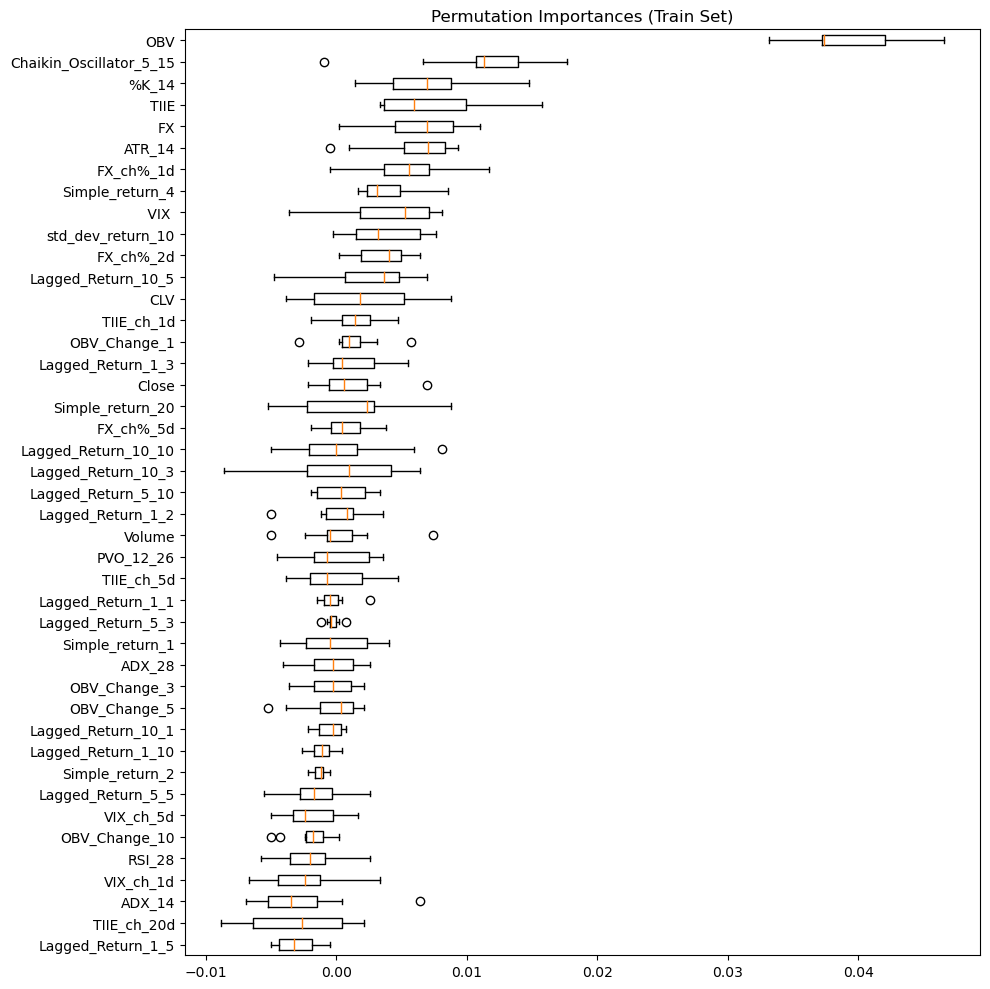

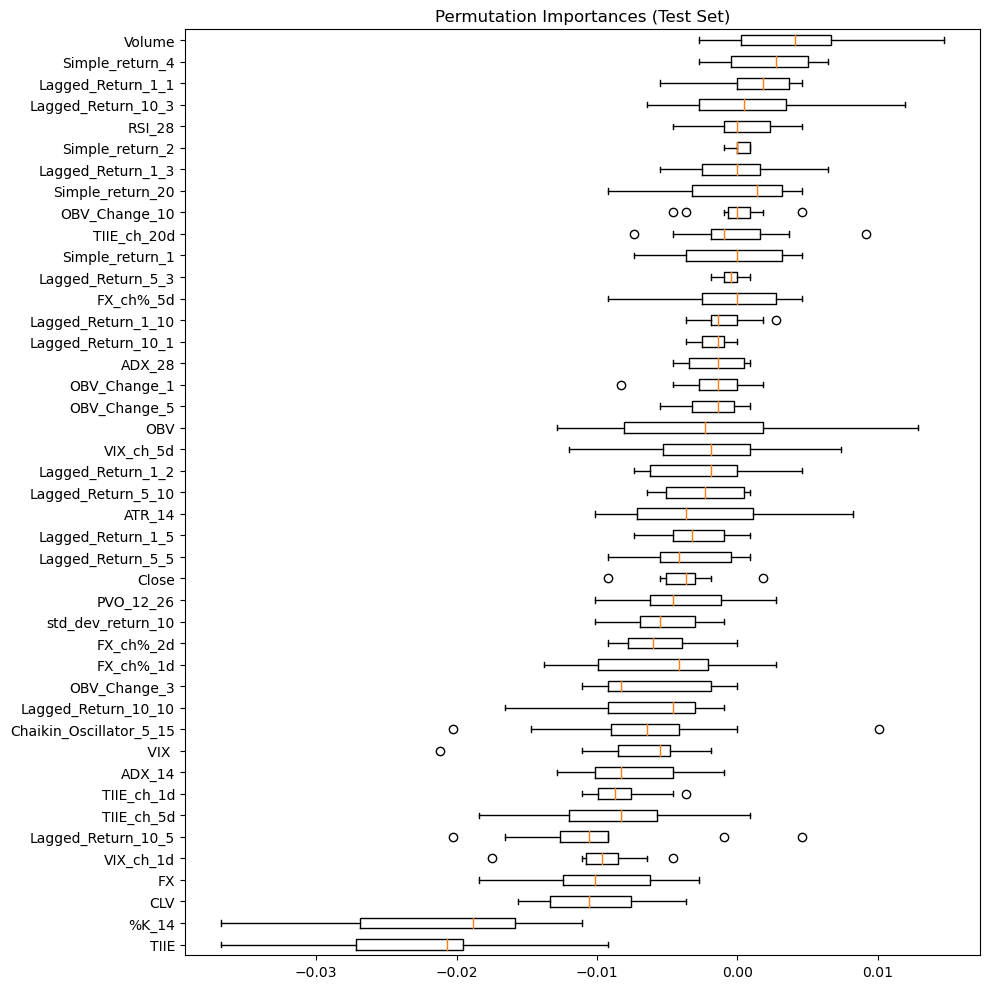

In [517]:
from sklearn.inspection import permutation_importance

# Extract feature columns
feature_columns = train_scaled_df.drop(columns=['return_category', 'Date', 'forward_return']).columns

# Convert scaled data back to DataFrame with only feature columns to ensure feature names are preserved
X_train_scaled_df = train_scaled_df[feature_columns]
X_test_scaled_df = test_scaled_df[feature_columns]

# Calculate permutation importance on the training set
result_train = permutation_importance(estimator=best_logistic_model, X=X_train_scaled_df, y=train_scaled_df['return_category'], n_repeats=10, random_state=1, n_jobs=2)

# Calculate permutation importance on the test set
result_test = permutation_importance(estimator=best_logistic_model, X=X_test_scaled_df, y=test_scaled_df['return_category'], n_repeats=10, random_state=1, n_jobs=2)

# Sort the features by their importance values (mean)
sorted_idx_train = result_train.importances_mean.argsort()
sorted_idx_test = result_test.importances_mean.argsort()

# Function to plot permutation importances
def plot_perm_importance(result, sorted_idx, feature_names, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

# Convert feature names to a NumPy array for indexing
feature_names = np.array(feature_columns)

# Plot permutation importances for the training set
plot_perm_importance(result_train, sorted_idx_train, feature_names, "Permutation Importances (Train Set)")

# Plot permutation importances for the test set
plot_perm_importance(result_test, sorted_idx_test, feature_names, "Permutation Importances (Test Set)")

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


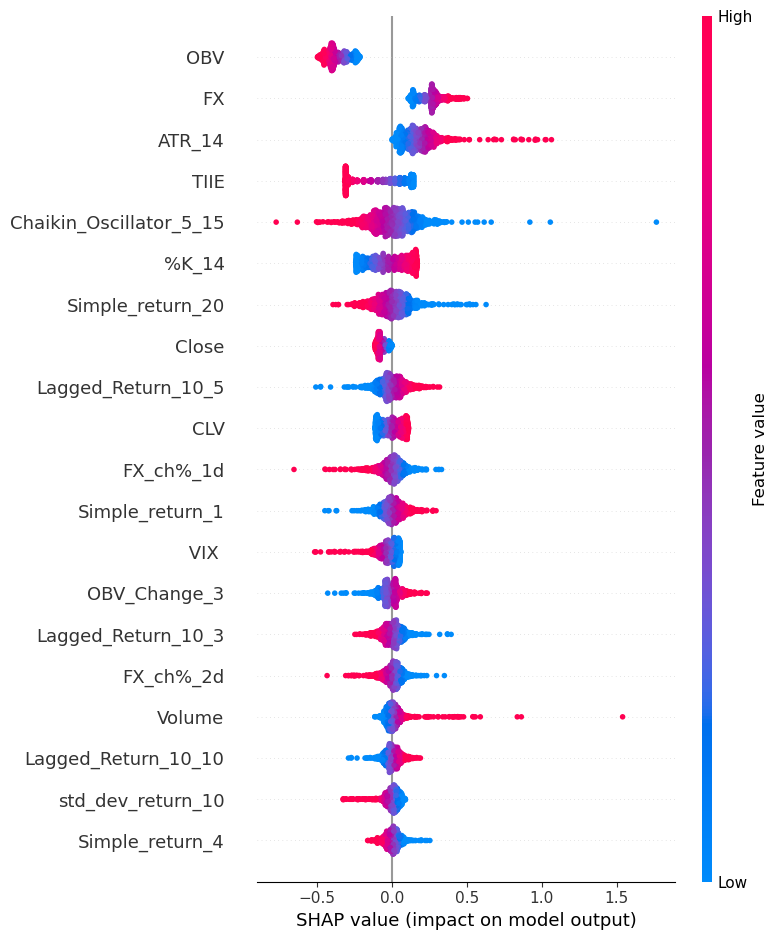

In [518]:
import shap

# SHAP Values for Logistic Regression
# Note: SHAP can be applied to logistic regression using the linear explainer
explainer = shap.LinearExplainer(best_logistic_model, X_train_scaled_df, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_scaled_df)

# Create the summary plot
shap.summary_plot(shap_values, X_test_scaled_df, feature_names=X_test_scaled_df.columns)

# Optionally, you can also plot SHAP dependence and other plots
# shap.dependence_plot("FeatureName", shap_values, X_test_scaled_df)

forward_return_bucket
-0.005 to 0.0      226
0.0 to 0.005       212
0.005 to 0.01      152
-0.01 to -0.005    148
0.01 to 0.015       90
-0.015 to -0.01     83
0.015 to 0.02       51
-0.02 to -0.015     46
0.02 to 0.025       24
-0.025 to -0.02     17
0.025 to 0.03       11
-0.03 to -0.025      9
0.03 to 0.035        4
-0.065 to -0.06      3
0.035 to 0.04        3
-0.035 to -0.03      3
-0.04 to -0.035      2
-0.055 to -0.05      2
0.04 to 0.045        1
0.065 to 0.07        0
0.06 to 0.065        0
0.055 to 0.06        0
0.05 to 0.055        0
-0.07 to -0.065      0
0.045 to 0.05        0
-0.045 to -0.04      0
-0.05 to -0.045      0
-0.06 to -0.055      0
0.07 to 0.075        0
Name: count, dtype: int64
   Forward Return Bucket  Prediction Accuracy
0        -0.07 to -0.065                  NaN
1        -0.065 to -0.06             0.666667
2        -0.06 to -0.055                  NaN
3        -0.055 to -0.05             0.000000
4        -0.05 to -0.045                  NaN
5        

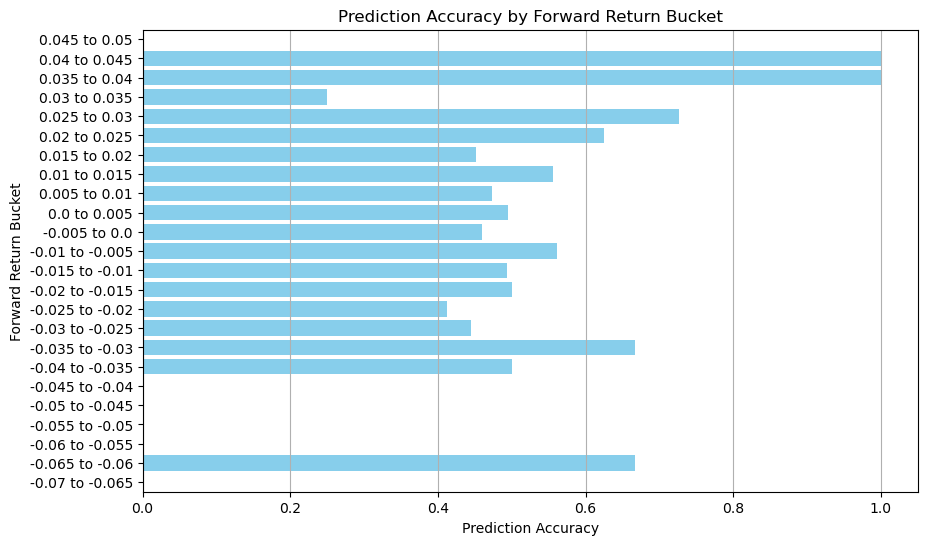

In [519]:
# Create a copy of the test DataFrame to ensure the original is not altered
test_df_copy = test_df.copy()

# Define bins for forward_return in steps of 0.005
bins = np.arange(-0.07, 0.07 + 0.005, 0.005)
labels = [f"{round(b, 3)} to {round(b + 0.005, 3)}" for b in bins[:-1]]
test_df_copy['forward_return_bucket'] = pd.cut(test_df_copy['forward_return'], bins=bins, labels=labels, include_lowest=True)

# Verify the distribution of samples in each bucket
bucket_counts = test_df_copy['forward_return_bucket'].value_counts()
print(bucket_counts)

# Filter out buckets with very small values or null
min_samples_per_bucket = 1
valid_buckets = bucket_counts[bucket_counts >= min_samples_per_bucket].index
filtered_test_df = test_df_copy[test_df_copy['forward_return_bucket'].isin(valid_buckets)].copy()

# Get model predictions for the test set
test_predictions = best_logistic_model.predict(X_test_scaled_df)

# Ensure filtered_test_df and test_predictions are aligned
filtered_test_df = filtered_test_df.iloc[:len(test_predictions)].copy()

# Add predictions and true labels to the test DataFrame
filtered_test_df['predictions'] = test_predictions[:len(filtered_test_df)]
filtered_test_df['true_labels'] = test_scaled_df['return_category'][:len(filtered_test_df)].values

# Calculate accuracy within each bucket
bucket_accuracy = filtered_test_df.groupby('forward_return_bucket').apply(lambda x: (x['predictions'] == x['true_labels']).mean())

# Generate a summary report
report = bucket_accuracy.reset_index()
report.columns = ['Forward Return Bucket', 'Prediction Accuracy']

# Display the report
print(report)

# Optionally, plot the results for better visualization
plt.figure(figsize=(10, 6))
plt.barh(report['Forward Return Bucket'], report['Prediction Accuracy'], color='skyblue')
plt.xlabel('Prediction Accuracy')
plt.ylabel('Forward Return Bucket')
plt.title('Prediction Accuracy by Forward Return Bucket')
plt.grid(axis='x')
plt.show()

    Threshold  Accuracy  False Positives  False Negatives
0        0.40  0.518859              457               66
1        0.41  0.509660              445               88
2        0.42  0.516099              422              104
3        0.43  0.509660              402              131
4        0.44  0.508740              385              149
5        0.45  0.503220              365              175
6        0.46  0.494940              349              200
7        0.47  0.497700              327              219
8        0.48  0.499540              307              237
9        0.49  0.495860              296              252
10       0.50  0.501380              272              270
11       0.51  0.516099              239              287
12       0.52  0.517019              218              307
13       0.53  0.524379              191              326
14       0.54  0.528059              168              345
15       0.55  0.528979              144              368
16       0.56 

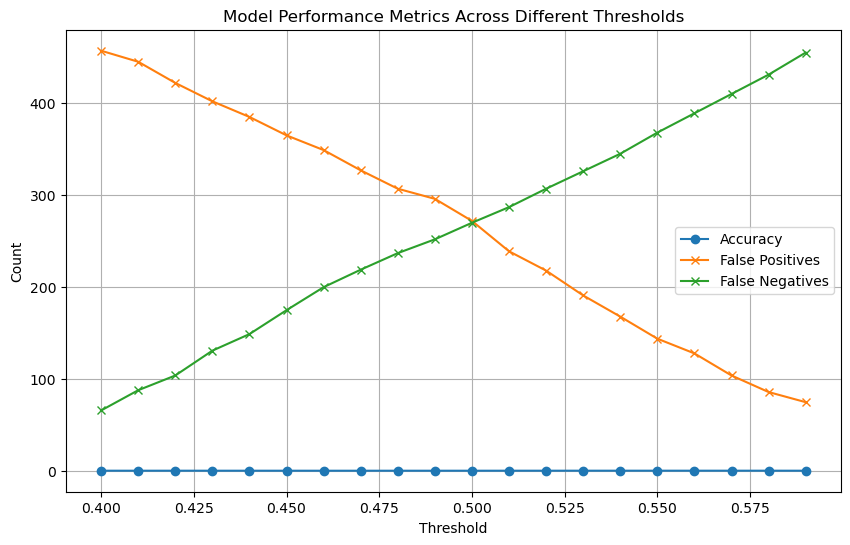

In [520]:

model = best_logistic_model

# Predict probabilities on the test set
y_test_proba = model.predict_proba(X_test_scaled_df)[:, 1]  # probabilities for the positive class

# Thresholds to test
thresholds = np.arange(0.4, 0.6, 0.01)  # From 0.4 to 0.6 with steps of 0.01
results = []

for thresh in thresholds:
    # Apply threshold to probability to create binary outcome
    y_test_pred_thresh = (y_test_proba >= thresh).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(test_scaled_df['return_category'], y_test_pred_thresh)

    # Calculate confusion matrix and extract false positives and false negatives
    tn, fp, fn, tp = confusion_matrix(test_scaled_df['return_category'], y_test_pred_thresh).ravel()

    # Append results
    results.append({
        'Threshold': thresh,
        'Accuracy': accuracy,
        'False Positives': fp,
        'False Negatives': fn
    })

# Convert results list to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Optionally, visualize the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['Threshold'], results_df['False Positives'], marker='x', label='False Positives')
plt.plot(results_df['Threshold'], results_df['False Negatives'], marker='x', label='False Negatives')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('Model Performance Metrics Across Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


# Model 2.2: Logistic regression with PCA inputs

In [522]:
# IDENTIFY THE BEST PARAMETERS AVOIDING OVERFITTING


# Call the grid search function with time series cross-validation
best_logistic_model, best_params, best_cv_score, results_df = manual_grid_search_logistic_cv(train_pca_df, param_grid)


Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
0,0.530086,0.030900,0.534384,"{'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
14,0.529799,0.031641,0.532235,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}"
10,0.529226,0.027966,0.532713,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}"
4,0.527221,0.035937,0.538682,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
12,0.526361,0.033813,0.535817,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
8,0.525788,0.031323,0.535817,"{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
1,0.523496,0.024018,0.542502,"{'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
5,0.523209,0.026377,0.541547,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
9,0.521777,0.014789,0.539398,"{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
13,0.521490,0.022887,0.537011,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"


Best Parameters: {'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.5300859598853869


In [523]:
# Evaluate the best model using the existing train_and_validate_model function

final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_pca_df, val_pca_df, best_logistic_model)

print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.5343839541547278
Final Model Validation Accuracy: 0.5555555555555556
----------------------------
Validation Confusion Matrix:
[[ 0 12]
 [ 0 15]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00        12
      N_&_Up       0.56      1.00      0.71        15

    accuracy                           0.56        27
   macro avg       0.28      0.50      0.36        27
weighted avg       0.31      0.56      0.40        27



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [524]:
# Train final model and test

final_logistic_model, test_accuracy, test_conf_matrix, test_report, train_time = train_final_model_and_test(train_pca_df, val_pca_df, test_pca_df, best_logistic_model)

print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.500459981600736
Training Time: 0.025149822235107422 seconds
----------------------------
Test Confusion Matrix:
[[  0 539]
 [  4 544]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00       539
      N_&_Up       0.50      0.99      0.67       548

    accuracy                           0.50      1087
   macro avg       0.25      0.50      0.33      1087
weighted avg       0.25      0.50      0.34      1087



In [525]:
predictions_B = best_logistic_model.predict(test_pca_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.11
Annualized Return: 2.41%
Annualized Standard Deviation: 18.01%
Sharpe Ratio: -0.07406418624574788


In [526]:
model_name="Logistic Reg - PCA"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 2.3: Logistic regression with reduced features

In [528]:
# IDENTIFY THE BEST PARAMETERS AVOIDING OVERFITTING

# Call the grid search function with time series cross-validation
best_logistic_model, best_params, best_cv_score, results_df = manual_grid_search_logistic_cv(train_rfe_df, param_grid)


Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
1,0.531519,0.029122,0.537966,"{'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
4,0.530086,0.033867,0.533190,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
0,0.529799,0.030999,0.534384,"{'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
8,0.527221,0.031545,0.542741,"{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
12,0.525501,0.029920,0.542502,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}"
5,0.522350,0.030453,0.541547,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
10,0.520917,0.028374,0.537011,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}"
9,0.520630,0.031028,0.544413,"{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
13,0.518625,0.025740,0.542264,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}"
6,0.518052,0.028490,0.531757,"{'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}"


Best Parameters: {'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.5315186246418337


In [529]:
# Evaluate the best model using the existing train_and_validate_model function

final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_rfe_df, val_rfe_df, best_logistic_model)

print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.5379656160458453
Final Model Validation Accuracy: 0.5185185185185185
----------------------------
Validation Confusion Matrix:
[[7 5]
 [8 7]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.47      0.58      0.52        12
      N_&_Up       0.58      0.47      0.52        15

    accuracy                           0.52        27
   macro avg       0.53      0.53      0.52        27
weighted avg       0.53      0.52      0.52        27



In [530]:
# Train final model and test

final_logistic_model, test_accuracy, test_conf_matrix, test_report, train_time = train_final_model_and_test(train_rfe_df, val_rfe_df, test_rfe_df, best_logistic_model)

print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5105795768169273
Training Time: 0.0728919506072998 seconds
----------------------------
Test Confusion Matrix:
[[330 209]
 [323 225]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.51      0.61      0.55       539
      N_&_Up       0.52      0.41      0.46       548

    accuracy                           0.51      1087
   macro avg       0.51      0.51      0.51      1087
weighted avg       0.51      0.51      0.51      1087



In [531]:
predictions_B = best_logistic_model.predict(test_rfe_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.78
Annualized Return: 13.79%
Annualized Standard Deviation: 10.86%
Sharpe Ratio: 0.8253112228121684


In [532]:
model_name="Logistic Reg - reduced features"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# SUPPORT VECTOR MACHINES

# Model 3.1: Support Vector MAchine with all features

In [535]:
from sklearn.svm import SVC

In [536]:
def manual_grid_search_svm_cv(train_df, param_grid, n_splits=5):
    # Extract features and target
    X_train = train_df.drop(columns=['return_category', 'Date', 'forward_return'])
    y_train = train_df['return_category']

    resultss = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Calculate total number of parameter combinations
    total_combinations = np.prod([len(values) for values in param_grid.values()])
    
    for i, params in enumerate(ParameterGrid(param_grid)):
        try:
            model = SVC(**params, random_state=42)
            cv_scores = []

            for train_index, val_index in tscv.split(X_train):
                X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

                model.fit(X_train_cv, y_train_cv)
                val_predictions = model.predict(X_val_cv)
                accuracy_val = accuracy_score(y_val_cv, val_predictions)
                cv_scores.append(accuracy_val)

            mean_cv_score = np.mean(cv_scores)
            std_cv_score = np.std(cv_scores)

            model.fit(X_train, y_train)
            train_predictions = model.predict(X_train)
            accuracy_train = accuracy_score(y_train, train_predictions)

            resultss.append({
                'params': params,
                'train_accuracy': accuracy_train,
                'cv_mean_accuracy': mean_cv_score,
                'cv_std_accuracy': std_cv_score
            })
        except ValueError as e:
            print(f"Skipping parameters {params} due to error: {e}")

        # Iteratively print the status
        clear_output(wait=True)
        print(f"Finished process {i+1} of a total of {total_combinations} combinations")

    # Clear the display before the final print
    clear_output(wait=True)
    
    results_dff = pd.DataFrame(resultss)
    results_dff = results_dff.sort_values(by='cv_mean_accuracy', ascending=False)

    best_params = results_dff.iloc[0]['params']
    best_score = results_dff.iloc[0]['cv_mean_accuracy']
    best_model = SVC(**best_params, random_state=42)
    best_model.fit(X_train, y_train)

    pd.set_option('display.max_colwidth', 150)
    print("Top 10 hyperparameter combinations based on cross-validation accuracy:")
    display(results_dff[['cv_mean_accuracy', 'cv_std_accuracy', 'train_accuracy', 'params']].head(10))

    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score}")

    return best_model, best_params, best_score, results_dff

In [537]:
# Search for the best parameters

if LongParamGrid==1:
    param_grid = {
    'C': [0.001, .01, .1],
    'kernel': ['rbf','poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
    }
else:
    param_grid = {
    'C': [0.001,.01, .1],
    'kernel': ['poly'],
    'gamma': ['auto'],
    'class_weight': ['balanced']
    }
    

In [538]:
best_svm_model, best_params, best_val_score, results_df = manual_grid_search_svm_cv(train_scaled_df, param_grid)

Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
5,0.530372,0.030813,0.551098,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
7,0.530372,0.028902,0.551098,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
11,0.530372,0.030906,0.633477,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
1,0.529799,0.030999,0.536772,"{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
3,0.529799,0.030999,0.536772,"{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
9,0.526074,0.032587,0.633477,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
8,0.507736,0.016325,0.560649,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}"
10,0.500287,0.025280,0.560649,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}"
4,0.496562,0.042861,0.466810,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}"
6,0.496562,0.042861,0.466810,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}"


Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}
Best Cross-Validation Score: 0.5303724928366762


In [539]:
# Evaluate the best model using the existing train_and_validate_model function

final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_scaled_df, val_scaled_df, best_svm_model)

print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.5510983763132761
Final Model Validation Accuracy: 0.5555555555555556
----------------------------
Validation Confusion Matrix:
[[ 0 12]
 [ 0 15]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00        12
      N_&_Up       0.56      1.00      0.71        15

    accuracy                           0.56        27
   macro avg       0.28      0.50      0.36        27
weighted avg       0.31      0.56      0.40        27



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [540]:
# Train final model and test

final_svm_model, test_accuracy, test_conf_matrix, test_report, train_time = train_final_model_and_test(train_scaled_df, val_scaled_df, test_scaled_df, best_svm_model)

print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5068997240110396
Training Time: 1.166111946105957 seconds
----------------------------
Test Confusion Matrix:
[[ 20 519]
 [ 17 531]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.54      0.04      0.07       539
      N_&_Up       0.51      0.97      0.66       548

    accuracy                           0.51      1087
   macro avg       0.52      0.50      0.37      1087
weighted avg       0.52      0.51      0.37      1087



In [541]:
predictions_B = best_svm_model.predict(test_scaled_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.17
Annualized Return: 3.61%
Annualized Standard Deviation: 17.78%
Sharpe Ratio: -0.009597626514331353


In [542]:
model_name="Support VM - ALL Inputs"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 3.2: Support Vector MAchine with PCA inputs

In [544]:
# Manual grid search

best_svm_model, best_params, best_val_score, results_df = manual_grid_search_svm_cv(train_pca_df, param_grid)

Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
5,0.531232,0.030030,0.550621,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
7,0.530659,0.026628,0.578080,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
11,0.530372,0.018885,0.626791,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
1,0.529799,0.030999,0.536772,"{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
9,0.525501,0.032283,0.560888,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
8,0.510602,0.011554,0.558978,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}"
4,0.496562,0.042861,0.466810,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}"
6,0.496562,0.042861,0.466810,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}"
3,0.485673,0.037447,0.557068,"{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
0,0.482808,0.039413,0.466810,"{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}"


Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}
Best Cross-Validation Score: 0.5312320916905444


In [545]:
# Evaluate the best model using the existing train_and_validate_model function

final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_pca_df, val_pca_df, best_svm_model)

print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.5506208213944603
Final Model Validation Accuracy: 0.5555555555555556
----------------------------
Validation Confusion Matrix:
[[ 0 12]
 [ 0 15]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00        12
      N_&_Up       0.56      1.00      0.71        15

    accuracy                           0.56        27
   macro avg       0.28      0.50      0.36        27
weighted avg       0.31      0.56      0.40        27



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [546]:
# Train final model and test

final_svm_model, test_accuracy, test_conf_matrix, test_report, train_time = train_final_model_and_test(train_pca_df, val_pca_df, test_pca_df, best_svm_model)

print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.500459981600736
Training Time: 0.9918339252471924 seconds
----------------------------
Test Confusion Matrix:
[[ 29 510]
 [ 33 515]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.47      0.05      0.10       539
      N_&_Up       0.50      0.94      0.65       548

    accuracy                           0.50      1087
   macro avg       0.49      0.50      0.38      1087
weighted avg       0.49      0.50      0.38      1087



In [547]:
predictions_B = best_svm_model.predict(test_pca_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.23
Annualized Return: 4.80%
Annualized Standard Deviation: 16.76%
Sharpe Ratio: 0.050103535618651246


In [548]:
model_name="Support VM - PCA"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 3.3: Support Vector MAchine with reduced features

In [550]:
# Manual grid search

best_svm_model, best_params, best_val_score, results_df = manual_grid_search_svm_cv(train_rfe_df, param_grid)

Top 10 hyperparameter combinations based on cross-validation accuracy:


,cv_mean_accuracy,cv_std_accuracy,train_accuracy,params
11,0.533238,0.035793,0.598138,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
9,0.532665,0.035827,0.598138,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
10,0.503152,0.019694,0.556113,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}"
8,0.500573,0.021530,0.556113,"{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}"
4,0.496562,0.042861,0.466810,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}"
6,0.496562,0.042861,0.466810,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}"
1,0.495702,0.043266,0.535817,"{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"
3,0.495702,0.043266,0.535817,"{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
7,0.495129,0.043593,0.547755,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}"
5,0.494556,0.042898,0.547755,"{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}"


Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'poly'}
Best Cross-Validation Score: 0.5332378223495703


In [551]:
# Evaluate the best model using the existing train_and_validate_model function

final_model, accuracy_val, conf_matrix, report, accuracy_train = train_and_validate_model(train_rfe_df, val_rfe_df, best_svm_model)

print("----------------------------")
print(f"Final Model Train Accuracy: {accuracy_train}")
print(f"Final Model Validation Accuracy: {accuracy_val}")
print("----------------------------")
print(f"Validation Confusion Matrix:\n{conf_matrix}")
print(f"Validation Classification Report:\n{report}")

----------------------------
Final Model Train Accuracy: 0.5981375358166189
Final Model Validation Accuracy: 0.48148148148148145
----------------------------
Validation Confusion Matrix:
[[ 8  4]
 [10  5]]
Validation Classification Report:
              precision    recall  f1-score   support

        down       0.44      0.67      0.53        12
      N_&_Up       0.56      0.33      0.42        15

    accuracy                           0.48        27
   macro avg       0.50      0.50      0.47        27
weighted avg       0.51      0.48      0.47        27



In [552]:
# Train final model and test

final_svm_model, test_accuracy, test_conf_matrix, test_report, train_time = train_final_model_and_test(train_rfe_df, val_rfe_df, test_rfe_df, best_svm_model)

print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.49310027598896045
Training Time: 1.0568029880523682 seconds
----------------------------
Test Confusion Matrix:
[[382 157]
 [394 154]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.49      0.71      0.58       539
      N_&_Up       0.50      0.28      0.36       548

    accuracy                           0.49      1087
   macro avg       0.49      0.49      0.47      1087
weighted avg       0.49      0.49      0.47      1087



In [553]:
predictions_B = best_svm_model.predict(test_rfe_df.drop(columns=['return_category', 'Date', 'forward_return']))

print(f"Investment strategy in Test set\n")
iresults_df, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_B)

Investment strategy in Test set

Final Investment Amount: $1.40
Annualized Return: 7.85%
Annualized Standard Deviation: 10.30%
Sharpe Ratio: 0.2906527101540393


In [554]:
model_name="Support VM - reduced features"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# NEURAL NETWORK MODELS

In [556]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from time import time

# Model 4.1: Simple Artificial Neural Network + All features

### Train and test functions adapted to Neural NEtworks

In [559]:
def train_and_validate_best_nn(train_df, val_df, model_class, best_params):
    X_train = torch.tensor(train_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y_train = torch.tensor(train_df['return_category'].values, dtype=torch.float32).view(-1, 1)
    X_val = torch.tensor(val_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y_val = torch.tensor(val_df['return_category'].values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    model = model_class(input_dim=X_train.shape[1], hidden_dim=best_params['hidden_dim'], output_dim=1)
    criterion = nn.BCELoss()
    optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

    model, train_accuracy, val_accuracy, train_time = train_and_validate_nn(train_loader, val_loader, model, criterion, optimizer, best_params['epochs'])

    return model, train_accuracy, val_accuracy, train_time

def train_and_validate_nn(train_loader, val_loader, model, criterion, optimizer, epochs):
    start_time = time()
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        train_correct = 0
        train_total = 0
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
        train_accuracy = train_correct / train_total

        val_correct = 0
        val_total = 0
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
        val_accuracy = val_correct / val_total
    
    elapsed_time = time() - start_time
    return model, train_accuracy, val_accuracy, elapsed_time
    
def train_final_nn_model_and_test(train_df, val_df, test_df, model_class, best_params):
    X_train_val = torch.tensor(pd.concat([train_df.drop(columns=['return_category', 'Date', 'forward_return']), 
                                          val_df.drop(columns=['return_category', 'Date', 'forward_return'])]).values, dtype=torch.float32)
    y_train_val = torch.tensor(pd.concat([train_df['return_category'], val_df['return_category']]).values, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(test_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y_test = torch.tensor(test_df['return_category'].values, dtype=torch.float32).view(-1, 1)

    train_val_dataset = TensorDataset(X_train_val, y_train_val)
    test_dataset = TensorDataset(X_test, y_test)

    model = model_class(input_dim=X_train_val.shape[1], hidden_dim=best_params['hidden_dim'], output_dim=1)
    criterion = nn.BCELoss()
    optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

    train_val_loader = DataLoader(train_val_dataset, batch_size=best_params['batch_size'], shuffle=True)

    model, _, _, _ = train_and_validate_nn(train_val_loader, train_val_loader, model, criterion, optimizer, best_params['epochs'])

    start_time = time()

    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)
        test_correct = 0
        test_total = 0
        test_predictions = []
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()
            test_predictions.extend(predicted.numpy())
        test_accuracy = test_correct / test_total
        test_conf_matrix = confusion_matrix(y_test.numpy(), test_predictions)
        test_report = classification_report(y_test.numpy(), test_predictions, target_names=['down', 'N_&_Up'])

    end_time = time()
    train_time = end_time - start_time
    
    return model, test_accuracy, test_conf_matrix, test_report,train_time

### Grid search function for NN

In [561]:
def manual_grid_search_nn(train_df, param_grid, model_class, n_splits=5):
    # Extract features and target
    X = torch.tensor(train_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y = torch.tensor(train_df['return_category'].values, dtype=torch.float32).view(-1, 1)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    
    # Calculate total number of parameter combinations
    total_combinations = np.prod([len(values) for values in param_grid.values()])
    
    for i, params in enumerate(ParameterGrid(param_grid)):
        cv_scores = []
        for train_index, val_index in tscv.split(X):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            y_train_cv, y_val_cv = y[train_index], y[val_index]

            train_dataset = TensorDataset(X_train_cv, y_train_cv)
            val_dataset = TensorDataset(X_val_cv, y_val_cv)
            train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

            model = model_class(input_dim=X_train_cv.shape[1], hidden_dim=params['hidden_dim'], output_dim=1)
            criterion = nn.BCELoss()
            optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

            model, train_accuracy, val_accuracy, train_time = train_and_validate_nn(train_loader, val_loader, model, criterion, optimizer, params['epochs'])
            cv_scores.append(val_accuracy)

        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        results.append({
            'params': params,
            'train_accuracy': train_accuracy,
            'cv_mean_accuracy': mean_cv_score,
            'cv_std_accuracy': std_cv_score
        })
        
        # Iteratively print the status
        clear_output(wait=True)
        print(f"Finished process {i+1} of a total of {total_combinations} combinations")

    # Clear the display before the final print
    clear_output(wait=True)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='cv_mean_accuracy', ascending=False)

    best_params = results_df.iloc[0]['params']
    best_model = model_class(input_dim=X.shape[1], hidden_dim=best_params['hidden_dim'], output_dim=1)
    criterion = nn.BCELoss()
    optimizer = getattr(optim, best_params['optimizer'])(best_model.parameters(), lr=best_params['lr'])

    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

    best_model, _, _, _ = train_and_validate_nn(train_loader, train_loader, best_model, criterion, optimizer, best_params['epochs'])

    print("Top 10 hyperparameter combinations based on validation accuracy:")
    display(results_df[['cv_mean_accuracy', 'train_accuracy', 'params']].head(10))

    print(f"Best Parameters: {best_params}")

    return best_model, best_params, results_df

### Architecture and parameters

In [563]:
class SimpleANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

#Define parameter grid

if LongParamGrid==1:
    param_grid = {
    'hidden_dim': [5,10,30],
    'optimizer': ['Adam','SGD'],
    'lr': [0.01, 0.001],
    'batch_size': [16,32],
    'epochs': [10,20,30]
    }
else:
    param_grid = {
    'hidden_dim': [5,10],
    'optimizer': ['SGD'],
    'lr': [0.01, 0.001],
    'batch_size': [32],
    'epochs': [20,30]
    }


### Run with all features

In [565]:
# Perform grid search with time series cross-validation
best_nn_model, best_nn_params, nn_results_df = manual_grid_search_nn(train_scaled_df, param_grid, SimpleANN, n_splits=5)


Top 10 hyperparameter combinations based on validation accuracy:


,cv_mean_accuracy,train_accuracy,params
10,0.538395,0.620344,"{'batch_size': 16, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}"
53,0.537249,0.554441,"{'batch_size': 32, 'epochs': 20, 'hidden_dim': 10, 'lr': 0.01, 'optimizer': 'SGD'}"
6,0.534384,0.588825,"{'batch_size': 16, 'epochs': 10, 'hidden_dim': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
33,0.534097,0.597994,"{'batch_size': 16, 'epochs': 30, 'hidden_dim': 30, 'lr': 0.01, 'optimizer': 'SGD'}"
42,0.532665,0.583095,"{'batch_size': 32, 'epochs': 10, 'hidden_dim': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
46,0.532092,0.605731,"{'batch_size': 32, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}"
49,0.531805,0.546991,"{'batch_size': 32, 'epochs': 20, 'hidden_dim': 5, 'lr': 0.01, 'optimizer': 'SGD'}"
25,0.531519,0.566189,"{'batch_size': 16, 'epochs': 30, 'hidden_dim': 5, 'lr': 0.01, 'optimizer': 'SGD'}"
62,0.529513,0.602006,"{'batch_size': 32, 'epochs': 30, 'hidden_dim': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
13,0.527507,0.564470,"{'batch_size': 16, 'epochs': 20, 'hidden_dim': 5, 'lr': 0.01, 'optimizer': 'SGD'}"


Best Parameters: {'batch_size': 16, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}


In [566]:
final_nn_model, train_accuracy, val_accuracy, train_time = train_and_validate_best_nn(train_scaled_df, val_scaled_df, SimpleANN, best_nn_params)

# Print final validation results
print("----------------------------")
print(f"Final Model Train Accuracy: {train_accuracy}")
print(f"Final Model Validation Accuracy: {val_accuracy}")
print("----------------------------")

----------------------------
Final Model Train Accuracy: 0.6095988538681948
Final Model Validation Accuracy: 0.5185185185185185
----------------------------


In [567]:
final_nn_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_nn_model_and_test(train_scaled_df, val_scaled_df, test_scaled_df, SimpleANN, best_nn_params)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5206991720331187
Training Time: 0.05604124069213867 seconds
----------------------------
Test Confusion Matrix:
[[252 287]
 [234 314]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.52      0.47      0.49       539
      N_&_Up       0.52      0.57      0.55       548

    accuracy                           0.52      1087
   macro avg       0.52      0.52      0.52      1087
weighted avg       0.52      0.52      0.52      1087



In [568]:
# Use model predictions
X_test_tensor = torch.tensor(test_scaled_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
predictions_nn = final_nn_model(X_test_tensor)
predictions_nn = (predictions_nn > 0.5).float().numpy()

# Evaluate investment strategy performance
print(f"Investment strategy results\n")
results_df_nn, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_nn)


Investment strategy results

Final Investment Amount: $1.78
Annualized Return: 13.69%
Annualized Standard Deviation: 14.29%
Sharpe Ratio: 0.6534057940629512


In [569]:
model_name="Neural N - Simple - ALL Inputs"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 4.2: Simple Artificial Neural Network + PCA inputs

In [571]:
# Perform grid search with time series cross-validation
best_nn_model, best_nn_params, nn_results_df = manual_grid_search_nn(train_pca_df, param_grid, SimpleANN, n_splits=5)

Top 10 hyperparameter combinations based on validation accuracy:


,cv_mean_accuracy,train_accuracy,params
21,0.542693,0.573926,"{'batch_size': 16, 'epochs': 20, 'hidden_dim': 30, 'lr': 0.01, 'optimizer': 'SGD'}"
69,0.534957,0.561032,"{'batch_size': 32, 'epochs': 30, 'hidden_dim': 30, 'lr': 0.01, 'optimizer': 'SGD'}"
65,0.534670,0.547851,"{'batch_size': 32, 'epochs': 30, 'hidden_dim': 10, 'lr': 0.01, 'optimizer': 'SGD'}"
44,0.534384,0.590544,"{'batch_size': 32, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.01, 'optimizer': 'Adam'}"
13,0.533238,0.553582,"{'batch_size': 16, 'epochs': 20, 'hidden_dim': 5, 'lr': 0.01, 'optimizer': 'SGD'}"
10,0.532665,0.578223,"{'batch_size': 16, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}"
71,0.531232,0.547278,"{'batch_size': 32, 'epochs': 30, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'SGD'}"
12,0.530372,0.563610,"{'batch_size': 16, 'epochs': 20, 'hidden_dim': 5, 'lr': 0.01, 'optimizer': 'Adam'}"
26,0.530086,0.573926,"{'batch_size': 16, 'epochs': 30, 'hidden_dim': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
22,0.529513,0.584527,"{'batch_size': 16, 'epochs': 20, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}"


Best Parameters: {'batch_size': 16, 'epochs': 20, 'hidden_dim': 30, 'lr': 0.01, 'optimizer': 'SGD'}


In [572]:
final_nn_model, train_accuracy, val_accuracy, train_time = train_and_validate_best_nn(train_pca_df, val_pca_df, SimpleANN, best_nn_params)

# Print final validation results
print("----------------------------")
print(f"Final Model Train Accuracy: {train_accuracy}")
print(f"Final Model Validation Accuracy: {val_accuracy}")
print("----------------------------")

----------------------------
Final Model Train Accuracy: 0.5527698185291309
Final Model Validation Accuracy: 0.6666666666666666
----------------------------


In [573]:
final_nn_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_nn_model_and_test(train_pca_df, val_pca_df, test_pca_df, SimpleANN, best_nn_params)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5188592456301748
Training Time: 0.03552365303039551 seconds
----------------------------
Test Confusion Matrix:
[[288 251]
 [272 276]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.51      0.53      0.52       539
      N_&_Up       0.52      0.50      0.51       548

    accuracy                           0.52      1087
   macro avg       0.52      0.52      0.52      1087
weighted avg       0.52      0.52      0.52      1087



In [574]:
# Use model predictions
X_test_tensor = torch.tensor(test_pca_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
predictions_nn = final_nn_model(X_test_tensor)
predictions_nn = (predictions_nn > 0.5).float().numpy()

# Evaluate investment strategy performance
print(f"Investment strategy results\n")
results_df_nn, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_nn)


Investment strategy results

Final Investment Amount: $1.72
Annualized Return: 12.79%
Annualized Standard Deviation: 11.97%
Sharpe Ratio: 0.6766631807087624


In [575]:
model_name="Neural N - Simple - PCA"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 4.3: Simple Artificial Neural Network + Reduced Features

In [577]:
# Perform grid search with time series cross-validation
best_nn_model, best_nn_params, nn_results_df = manual_grid_search_nn(train_rfe_df, param_grid, SimpleANN, n_splits=5)

Top 10 hyperparameter combinations based on validation accuracy:


,cv_mean_accuracy,train_accuracy,params
63,0.537822,0.540401,"{'batch_size': 32, 'epochs': 30, 'hidden_dim': 5, 'lr': 0.001, 'optimizer': 'SGD'}"
9,0.536676,0.550716,"{'batch_size': 16, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.01, 'optimizer': 'SGD'}"
17,0.535530,0.544699,"{'batch_size': 16, 'epochs': 20, 'hidden_dim': 10, 'lr': 0.01, 'optimizer': 'SGD'}"
49,0.531232,0.546705,"{'batch_size': 32, 'epochs': 20, 'hidden_dim': 5, 'lr': 0.01, 'optimizer': 'SGD'}"
46,0.530659,0.571920,"{'batch_size': 32, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}"
26,0.529799,0.561605,"{'batch_size': 16, 'epochs': 30, 'hidden_dim': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
3,0.528940,0.514327,"{'batch_size': 16, 'epochs': 10, 'hidden_dim': 5, 'lr': 0.001, 'optimizer': 'SGD'}"
10,0.528940,0.581089,"{'batch_size': 16, 'epochs': 10, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}"
58,0.528367,0.593410,"{'batch_size': 32, 'epochs': 20, 'hidden_dim': 30, 'lr': 0.001, 'optimizer': 'Adam'}"
25,0.527794,0.550716,"{'batch_size': 16, 'epochs': 30, 'hidden_dim': 5, 'lr': 0.01, 'optimizer': 'SGD'}"


Best Parameters: {'batch_size': 32, 'epochs': 30, 'hidden_dim': 5, 'lr': 0.001, 'optimizer': 'SGD'}


In [578]:
final_nn_model, train_accuracy, val_accuracy, train_time = train_and_validate_best_nn(train_rfe_df, val_rfe_df, SimpleANN, best_nn_params)

# Print final validation results
print("----------------------------")
print(f"Final Model Train Accuracy: {train_accuracy}")
print(f"Final Model Validation Accuracy: {val_accuracy}")
print("----------------------------")

----------------------------
Final Model Train Accuracy: 0.5300859598853869
Final Model Validation Accuracy: 0.48148148148148145
----------------------------


In [579]:
final_nn_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_nn_model_and_test(train_rfe_df, val_rfe_df, test_rfe_df, SimpleANN, best_nn_params)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5032198712051518
Training Time: 0.030224084854125977 seconds
----------------------------
Test Confusion Matrix:
[[ 15 524]
 [ 16 532]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.48      0.03      0.05       539
      N_&_Up       0.50      0.97      0.66       548

    accuracy                           0.50      1087
   macro avg       0.49      0.50      0.36      1087
weighted avg       0.49      0.50      0.36      1087



In [580]:
# Use model predictions
X_test_tensor = torch.tensor(test_rfe_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
predictions_nn = final_nn_model(X_test_tensor)
predictions_nn = (predictions_nn > 0.5).float().numpy()

# Evaluate investment strategy performance
print(f"Investment strategy results\n")
results_df_nn, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_nn)


Investment strategy results

Final Investment Amount: $1.24
Annualized Return: 4.91%
Annualized Standard Deviation: 17.60%
Sharpe Ratio: 0.06260367194650554


In [581]:
model_name="Neural N - Simple - Reduced features"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# DEEPER Neural Network

# Model 5.1: Deeper Neural Network with all features

### Train and test functions adapted to Neural NEtworks

In [585]:
def train_and_validate_best_deeper_nn(train_df, val_df, model_class, best_params):
    X_train = torch.tensor(train_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y_train = torch.tensor(train_df['return_category'].values, dtype=torch.float32).view(-1, 1)
    X_val = torch.tensor(val_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y_val = torch.tensor(val_df['return_category'].values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    model = model_class(input_dim=X_train.shape[1], hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], hidden_dim3=best_params['hidden_dim3'], output_dim=1)
    criterion = nn.BCELoss()
    optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

    model, train_accuracy, val_accuracy, train_time = train_and_validate_nn(train_loader, val_loader, model, criterion, optimizer, best_params['epochs'])

    return model, train_accuracy, val_accuracy, train_time

def train_final_deeper_nn_model_and_test(train_df, val_df, test_df, model_class, best_params):
    X_train_val = torch.tensor(pd.concat([train_df.drop(columns=['return_category', 'Date', 'forward_return']), 
                                          val_df.drop(columns=['return_category', 'Date', 'forward_return'])]).values, dtype=torch.float32)
    y_train_val = torch.tensor(pd.concat([train_df['return_category'], val_df['return_category']]).values, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(test_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y_test = torch.tensor(test_df['return_category'].values, dtype=torch.float32).view(-1, 1)

    train_val_dataset = TensorDataset(X_train_val, y_train_val)
    test_dataset = TensorDataset(X_test, y_test)

    model = model_class(input_dim=X_train_val.shape[1], hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], hidden_dim3=best_params['hidden_dim3'], output_dim=1)
    criterion = nn.BCELoss()
    optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

    train_val_loader = DataLoader(train_val_dataset, batch_size=best_params['batch_size'], shuffle=True)

    model, _, _, _ = train_and_validate_nn(train_val_loader, train_val_loader, model, criterion, optimizer, best_params['epochs'])

    start_time = time()
    
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)
        test_correct = 0
        test_total = 0
        test_predictions = []
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()
            test_predictions.extend(predicted.numpy())
        test_accuracy = test_correct / test_total
        test_conf_matrix = confusion_matrix(y_test.numpy(), test_predictions)
        test_report = classification_report(y_test.numpy(), test_predictions, target_names=['down', 'N_&_Up'])

    end_time = time()
    train_time=end_time-start_time

    return model, test_accuracy, test_conf_matrix, test_report,train_time

### Grid search function for NN

In [587]:
def manual_grid_search_deeper_nn(train_df, param_grid, model_class, n_splits=5):
    # Extract features and target
    X = torch.tensor(train_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
    y = torch.tensor(train_df['return_category'].values, dtype=torch.float32).view(-1, 1)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []

    # Calculate total number of parameter combinations
    total_combinations = np.prod([len(values) for values in param_grid.values()])

    for i, params in enumerate(ParameterGrid(param_grid)):
        cv_scores = []
        for train_index, val_index in tscv.split(X):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            y_train_cv, y_val_cv = y[train_index], y[val_index]

            train_dataset = TensorDataset(X_train_cv, y_train_cv)
            val_dataset = TensorDataset(X_val_cv, y_val_cv)
            train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

            model = model_class(input_dim=X_train_cv.shape[1], hidden_dim1=params['hidden_dim1'], hidden_dim2=params['hidden_dim2'], hidden_dim3=params['hidden_dim3'], output_dim=1)
            criterion = nn.BCELoss()
            optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

            model, train_accuracy, val_accuracy, train_time = train_and_validate_nn(train_loader, val_loader, model, criterion, optimizer, params['epochs'])
            cv_scores.append(val_accuracy)

        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        results.append({
            'params': params,
            'train_accuracy': train_accuracy,
            'cv_mean_accuracy': mean_cv_score,
            'cv_std_accuracy': std_cv_score
        })

        # Iteratively print the status
        clear_output(wait=True)
        print(f"Finished process {i+1} of a total of {total_combinations} combinations")

    # Clear the display before the final print
    clear_output(wait=True)
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='cv_mean_accuracy', ascending=False)

    best_params = results_df.iloc[0]['params']
    best_model = model_class(input_dim=X.shape[1], hidden_dim1=best_params['hidden_dim1'], hidden_dim2=best_params['hidden_dim2'], hidden_dim3=best_params['hidden_dim3'], output_dim=1)
    criterion = nn.BCELoss()
    optimizer = getattr(optim, best_params['optimizer'])(best_model.parameters(), lr=best_params['lr'])

    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

    best_model, _, _, _ = train_and_validate_nn(train_loader, train_loader, best_model, criterion, optimizer, best_params['epochs'])

    print("Top 10 hyperparameter combinations based on validation accuracy:")
    display(results_df[['cv_mean_accuracy', 'train_accuracy', 'params']].head(10))

    print(f"Best Parameters: {best_params}")

    return best_model, best_params, results_df

### Architecture and parameters

In [589]:
class DeeperANN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(DeeperANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

#Define parameter grid

if LongParamGrid==1:
    param_grid = {
    'hidden_dim1': [5, 10, 20],
    'hidden_dim2': [5, 10, 20],
    'hidden_dim3': [5, 10],
    'optimizer': ['Adam'],
    'lr': [0.01, 0.001],
    'batch_size': [10, 20],
    'epochs': [10, 20]
    }
else:
    param_grid = {
    'hidden_dim1': [10],
    'hidden_dim2': [10],
    'hidden_dim3': [5],
    'optimizer': ['Adam'],
    'lr': [0.01, 0.001],
    'batch_size': [20],
    'epochs': [10]
    }


### Run with all features

In [591]:
# Perform grid search with time series cross-validation
best_nn_model, best_nn_params, nn_results_df = manual_grid_search_deeper_nn(train_scaled_df, param_grid, DeeperANN, n_splits=5)

Top 10 hyperparameter combinations based on validation accuracy:


,cv_mean_accuracy,train_accuracy,params
113,0.538682,0.603438,"{'batch_size': 20, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
1,0.537822,0.579370,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 5, 'hidden_dim2': 5, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
5,0.537822,0.602865,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
89,0.536103,0.606590,"{'batch_size': 20, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
121,0.535244,0.628367,"{'batch_size': 20, 'epochs': 20, 'hidden_dim1': 10, 'hidden_dim2': 5, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
45,0.533524,0.594556,"{'batch_size': 10, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 20, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
131,0.532951,0.636390,"{'batch_size': 20, 'epochs': 20, 'hidden_dim1': 10, 'hidden_dim2': 20, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
19,0.532665,0.606304,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 10, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
87,0.532378,0.581089,"{'batch_size': 20, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 5, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
24,0.532092,0.516619,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 20, 'hidden_dim2': 5, 'hidden_dim3': 5, 'lr': 0.01, 'optimizer': 'Adam'}"


Best Parameters: {'batch_size': 20, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}


In [592]:
final_nn_model, train_accuracy, val_accuracy, train_time = train_and_validate_best_deeper_nn(train_scaled_df, val_scaled_df, DeeperANN, best_nn_params)

# Print final validation results
print("----------------------------")
print(f"Final Model Train Accuracy: {train_accuracy}")
print(f"Final Model Validation Accuracy: {val_accuracy}")
print("----------------------------")

----------------------------
Final Model Train Accuracy: 0.5921680993314231
Final Model Validation Accuracy: 0.5925925925925926
----------------------------


In [593]:
final_nn_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_deeper_nn_model_and_test(train_scaled_df, val_scaled_df, test_scaled_df, DeeperANN, best_nn_params)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5142594296228151
Training Time: 0.0733790397644043 seconds
----------------------------
Test Confusion Matrix:
[[335 204]
 [324 224]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.51      0.62      0.56       539
      N_&_Up       0.52      0.41      0.46       548

    accuracy                           0.51      1087
   macro avg       0.52      0.52      0.51      1087
weighted avg       0.52      0.51      0.51      1087



In [594]:
# Use model predictions
X_test_tensor = torch.tensor(test_scaled_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
predictions_nn = final_nn_model(X_test_tensor)
predictions_nn = (predictions_nn > 0.5).float().numpy()

# Evaluate investment strategy performance
results_df_nn, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_nn)


Final Investment Amount: $1.94
Annualized Return: 15.95%
Annualized Standard Deviation: 11.90%
Sharpe Ratio: 0.9448098628823967


In [595]:
model_name="Neural N - Deep - ALL Inputs"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 5.2: Deeper Artificial Neural Network + PCA inputs

In [597]:
# Perform grid search with time series cross-validation
best_nn_model, best_nn_params, nn_results_df = manual_grid_search_deeper_nn(train_pca_df, param_grid, DeeperANN, n_splits=5)

Top 10 hyperparameter combinations based on validation accuracy:


,cv_mean_accuracy,train_accuracy,params
21,0.541834,0.571060,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 20, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
77,0.540115,0.561605,"{'batch_size': 20, 'epochs': 10, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
23,0.539542,0.589685,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 20, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
7,0.539255,0.578223,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
115,0.536390,0.576791,"{'batch_size': 20, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
25,0.535817,0.592264,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 20, 'hidden_dim2': 5, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
28,0.535817,0.540688,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 20, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.01, 'optimizer': 'Adam'}"
103,0.534670,0.575931,"{'batch_size': 20, 'epochs': 10, 'hidden_dim1': 20, 'hidden_dim2': 10, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
117,0.533811,0.567622,"{'batch_size': 20, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 20, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
13,0.533524,0.572493,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 5, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"


Best Parameters: {'batch_size': 10, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 20, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}


In [598]:
final_nn_model, train_accuracy, val_accuracy, train_time = train_and_validate_best_deeper_nn(train_pca_df, val_pca_df, DeeperANN, best_nn_params)

# Print final validation results
print("----------------------------")
print(f"Final Model Train Accuracy: {train_accuracy}")
print(f"Final Model Validation Accuracy: {val_accuracy}")
print("----------------------------")

----------------------------
Final Model Train Accuracy: 0.5754536771728749
Final Model Validation Accuracy: 0.48148148148148145
----------------------------


In [599]:
final_nn_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_deeper_nn_model_and_test(train_pca_df, val_pca_df, test_pca_df, DeeperANN, best_nn_params)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5105795768169273
Training Time: 0.10980987548828125 seconds
----------------------------
Test Confusion Matrix:
[[ 66 473]
 [ 59 489]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.53      0.12      0.20       539
      N_&_Up       0.51      0.89      0.65       548

    accuracy                           0.51      1087
   macro avg       0.52      0.51      0.42      1087
weighted avg       0.52      0.51      0.43      1087



In [600]:
# Use model predictions
X_test_tensor = torch.tensor(test_pca_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
predictions_nn = final_nn_model(X_test_tensor)
predictions_nn = (predictions_nn > 0.5).float().numpy()

# Evaluate investment strategy performance
results_df_nn, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_nn)


Final Investment Amount: $1.20
Annualized Return: 4.16%
Annualized Standard Deviation: 17.13%
Sharpe Ratio: 0.01558879560166663


In [601]:
model_name="Neural N - Deep - PCA"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# Model 5.3: Deeper Artificial Neural Network + Reduced features

In [603]:
# Perform grid search with time series cross-validation
best_nn_model, best_nn_params, nn_results_df = manual_grid_search_deeper_nn(train_rfe_df, param_grid, DeeperANN, n_splits=5)

Top 10 hyperparameter combinations based on validation accuracy:


,cv_mean_accuracy,train_accuracy,params
41,0.543840,0.582235,"{'batch_size': 10, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
36,0.541834,0.574499,"{'batch_size': 10, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 5, 'hidden_dim3': 5, 'lr': 0.01, 'optimizer': 'Adam'}"
121,0.538109,0.594842,"{'batch_size': 20, 'epochs': 20, 'hidden_dim1': 10, 'hidden_dim2': 5, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
31,0.536963,0.604585,"{'batch_size': 10, 'epochs': 10, 'hidden_dim1': 20, 'hidden_dim2': 10, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
95,0.536103,0.581375,"{'batch_size': 20, 'epochs': 10, 'hidden_dim1': 10, 'hidden_dim2': 20, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
39,0.535817,0.588252,"{'batch_size': 10, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 5, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
103,0.533811,0.590258,"{'batch_size': 20, 'epochs': 10, 'hidden_dim1': 20, 'hidden_dim2': 10, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"
137,0.533524,0.599427,"{'batch_size': 20, 'epochs': 20, 'hidden_dim1': 20, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
65,0.533238,0.628367,"{'batch_size': 10, 'epochs': 20, 'hidden_dim1': 20, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}"
83,0.532951,0.579943,"{'batch_size': 20, 'epochs': 10, 'hidden_dim1': 5, 'hidden_dim2': 20, 'hidden_dim3': 10, 'lr': 0.001, 'optimizer': 'Adam'}"


Best Parameters: {'batch_size': 10, 'epochs': 20, 'hidden_dim1': 5, 'hidden_dim2': 10, 'hidden_dim3': 5, 'lr': 0.001, 'optimizer': 'Adam'}


In [604]:
final_nn_model, train_accuracy, val_accuracy, train_time = train_and_validate_best_deeper_nn(train_rfe_df, val_rfe_df, DeeperANN, best_nn_params)

# Print final validation results
print("----------------------------")
print(f"Final Model Train Accuracy: {train_accuracy}")
print(f"Final Model Validation Accuracy: {val_accuracy}")
print("----------------------------")

----------------------------
Final Model Train Accuracy: 0.5797516714422158
Final Model Validation Accuracy: 0.5555555555555556
----------------------------


In [605]:
final_nn_model, test_accuracy, test_conf_matrix, test_report,train_time = train_final_deeper_nn_model_and_test(train_rfe_df, val_rfe_df, test_rfe_df, DeeperANN, best_nn_params)

# Print test results
print("----------------------------")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training Time: {train_time} seconds")
print("----------------------------")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test Classification Report:\n{test_report}")

----------------------------
Test Accuracy: 0.5114995400183993
Training Time: 0.10907983779907227 seconds
----------------------------
Test Confusion Matrix:
[[330 209]
 [322 226]]
Test Classification Report:
              precision    recall  f1-score   support

        down       0.51      0.61      0.55       539
      N_&_Up       0.52      0.41      0.46       548

    accuracy                           0.51      1087
   macro avg       0.51      0.51      0.51      1087
weighted avg       0.51      0.51      0.51      1087



In [606]:
# Use model predictions
X_test_tensor = torch.tensor(test_rfe_df.drop(columns=['return_category', 'Date', 'forward_return']).values, dtype=torch.float32)
predictions_nn = final_nn_model(X_test_tensor)
predictions_nn = (predictions_nn > 0.5).float().numpy()

# Evaluate investment strategy performance
results_df_nn, final_investment_amount, annualized_return, annualized_std_dev, sharpe_ratio = investment_strategy_performance(test_df, predictions_nn)


Final Investment Amount: $1.39
Annualized Return: 7.67%
Annualized Standard Deviation: 12.54%
Sharpe Ratio: 0.24507803754077806


In [607]:
model_name="Neural N - Deep - Reduced features"

# Calculate Class 0 and Class 1 positive rates
test_class_0_positives = test_conf_matrix[0][0] / (test_conf_matrix[0][0] + test_conf_matrix[0][1])
test_class_1_positives = test_conf_matrix[1][1] / (test_conf_matrix[1][0] + test_conf_matrix[1][1])

# Create a DataFrame with the results
results = pd.DataFrame([{
    'Model': model_name,
    'Test Accuracy': test_accuracy*100,
    'Test Class 0 Positives %': test_class_0_positives * 100,
    'Test Class 1 Positives %': test_class_1_positives * 100,
    'Train Time': train_time,
    'Final_Investment': final_investment_amount,
    'Annu_Return': annualized_return,
    'Std_dev_Return': annualized_std_dev,
    'Sharpe': sharpe_ratio
}])

# Append the results to the main DataFrame
tresults_df = pd.concat([tresults_df, results], ignore_index=True)

# SUMMARY REPORT OF BEST CONFIGURATION FROM EACH MODEL

In [609]:
# Print the results DataFrame in a friendly format
tresults_df

,Model,Test Accuracy,Test Class 0 Positives %,Test Class 1 Positives %,Train Time,Final_Investment,Annu_Return,Std_dev_Return,Sharpe
0,Always Buy -Ref-,50.413983,0,100,0.000000,1.197108,0.040929,0.181775,0.021241
1,Always Sell -Ref-,49.586017,100,0,0.000000,1.425465,0.082250,0.004051,N/A
2,Random Forest - ALL Inputs,51.885925,46.19666,57.481752,2.218648,1.180667,0.037725,0.143250,-0.039049
3,Random Forest - PCA,52.253910,32.467532,71.715328,2.782748,1.604207,0.111135,0.147816,0.462223
4,Random Forest - Reduced features,51.977921,49.536178,54.379562,0.560546,1.840964,0.145768,0.142412,0.717183
5,Random Forest - Reduced features,51.977921,49.536178,54.379562,0.560546,1.840964,0.145768,0.142412,0.717183
6,Logistic Reg - PCA,50.045998,0.0,99.270073,0.025150,1.112588,0.024074,0.180070,-0.074064
7,Logistic Reg - reduced features,51.057958,61.22449,41.058394,0.072892,1.784995,0.137908,0.108582,0.825311
8,Support VM - ALL Inputs,50.689972,3.710575,96.89781,1.166112,1.172342,0.036089,0.177764,-0.009598
9,Support VM - PCA,50.045998,5.380334,93.978102,0.991834,1.233802,0.047960,0.167633,0.050104
